In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import RectBivariateSpline, griddata
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import Rbf
from scipy.misc import derivative
import itertools

In [4]:
df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/wTemp_wWind_0_cpu_log.csv')
df

,x,y,z,theta,time,phi
0,0.000000e+00,0.000000e+00,0.000000,-1.561820,0.0,0.000000
1,-6.711114e+02,-4.523426e+01,-15.339409,-1.625374,2.0,0.000000
2,-1.336794e+03,-1.034780e+02,-77.489862,-1.701462,4.0,0.000000
3,-1.985221e+03,-1.995073e+02,-200.693040,-1.809401,6.0,0.000000
4,-2.585298e+03,-3.914960e+02,-413.273320,-1.978404,8.0,0.000000
...,...,...,...,...,...,...
30887145,1.881431e+06,-6.666448e+06,-9084.109413,236.698808,88.0,3.141593
30887146,1.954672e+06,-6.924261e+06,-9459.104894,242.581968,90.0,3.141593
30887147,2.032794e+06,-7.199648e+06,-9540.418720,246.375777,92.0,3.141593
30887148,2.114541e+06,-7.490242e+06,-9974.954013,259.554301,94.0,3.141593


In [6]:
t = 46
group_t = df.groupby('time')
df_ = group_t.get_group(t)
df_.reset_index(drop=True)

,x,y,z,theta,time,phi
0,559232.509979,-1.994050e+06,-9248.154083,-46.330456,46.0,0.000000
1,512448.778081,-1.824784e+06,-8630.608484,-59.835209,46.0,0.000000
2,438347.609872,-1.570657e+06,-8946.279141,-50.706740,46.0,0.000000
3,509148.217687,-1.817993e+06,-8459.143148,-31.212170,46.0,0.000000
4,307771.666867,-1.113195e+06,-9004.591000,-11.281931,46.0,0.000000
...,...,...,...,...,...,...
630345,488704.479173,-1.746835e+06,-9310.108826,27.432973,46.0,3.141593
630346,420593.544259,-1.503808e+06,-6392.776741,6.067999,46.0,3.141593
630347,514190.498268,-1.838009e+06,-9118.244164,50.851447,46.0,3.141593
630348,513124.294341,-1.829809e+06,-9736.650070,35.560506,46.0,3.141593


In [9]:
df_[['x','y','z']].to_csv('testing_wavefront.csv', index=False)

In [46]:
x = df_['x'].values
y = df_['y'].values
z = df_['z'].values

points_ = np.column_stack((x, y))
values_ = z

num_samples = 12950
indices = np.random.choice(len(points_), num_samples, replace=False)
points_sampled = points_[indices]
values_sampled = values_[indices]

def evaluate_interpolation(epsilon, points, values):
    rbfi = RBFInterpolator(points, values, kernel='multiquadric', epsilon=epsilon)

    z_interp = rbfi(points)
    error = np.mean((values - z_interp)**2)
    
    return error


epsilons = np.logspace(-2, 1, 10)  # Epsilon values from 0.01 to 10
errors = []

for epsilon in epsilons:
    error = evaluate_interpolation(epsilon, points_sampled, values_sampled)
    errors.append(error)
    print(f"Epsilon: {epsilon}, Mean Squared Error: {error}")

plt.plot(epsilons, errors, marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.title('Interpolation Error vs. Epsilon')
plt.show()

best_epsilon = epsilons[np.argmin(errors)]
print(f"Best epsilon: {best_epsilon}")

rbfi = RBFInterpolator(points_sampled, values_sampled, kernel='multiquadric', epsilon=best_epsilon)


def interpolate_surface(xi, yi):
    return rbfi(np.column_stack((xi, yi)))


def partial_derivatives(xi, yi):
    eps = 1e-6 
    zx = (interpolate_surface(np.array([xi + eps]), np.array([yi])) - 
          interpolate_surface(np.array([xi - eps]), np.array([yi]))) / (2 * eps)
    zy = (interpolate_surface(np.array([xi]), np.array([yi + eps])) - 
          interpolate_surface(np.array([xi]), np.array([yi - eps]))) / (2 * eps)
    return zx[0], zy[0]

def normal_vector(xi, yi):
    zx, zy = partial_derivatives(xi, yi)
    normal = np.array([-zx, -zy, 1])
    return normal / np.linalg.norm(normal)

def intersection_xy_plane(xi, yi, zi, normal):
   
    nx, ny, nz = normal
    t = -zi / nz
    
    x_intersect = xi + t * nx
    y_intersect = yi + t * ny
    
    return x_intersect, y_intersect

# Example usage with the best epsilon
xi, yi = 513237.368361 , -1829410.0 # Point of interest
zi = interpolate_surface(np.array([xi]), np.array([yi]))[0]
normal = normal_vector(xi, yi)
x_intersect, y_intersect = intersection_xy_plane(xi, yi, zi, normal)

print(f"Point of interest: ({xi}, {yi}, {zi})")
print(f"Normal vector at ({xi}, {yi}): {normal}")
print(f"Intersection with x,y-plane: ({x_intersect}, {y_intersect})")

Epsilon: 0.01, Mean Squared Error: 2.8582136161786537e+115


LinAlgError: Singular matrix.

In [40]:
df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/wTemp_wWind_0_cpu_log.csv')
df

,x,y,z,theta,time,phi
0,0.000000e+00,0.000000e+00,0.000000,-1.561820,0.0,0.000000
1,-6.711114e+02,-4.523426e+01,-15.339409,-1.625374,2.0,0.000000
2,-1.336794e+03,-1.034780e+02,-77.489862,-1.701462,4.0,0.000000
3,-1.985221e+03,-1.995073e+02,-200.693040,-1.809401,6.0,0.000000
4,-2.585298e+03,-3.914960e+02,-413.273320,-1.978404,8.0,0.000000
...,...,...,...,...,...,...
30887145,1.881431e+06,-6.666448e+06,-9084.109413,236.698808,88.0,3.141593
30887146,1.954672e+06,-6.924261e+06,-9459.104894,242.581968,90.0,3.141593
30887147,2.032794e+06,-7.199648e+06,-9540.418720,246.375777,92.0,3.141593
30887148,2.114541e+06,-7.490242e+06,-9974.954013,259.554301,94.0,3.141593


In [17]:
df['time'].unique()

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76.,
       78., 80., 82., 84., 86., 88., 90., 92., 94., 96.])

In [18]:
df[df['time'] == 90]

,x,y,z,theta,time,phi
45,1.057053e+06,-3.746333e+06,2377.088828,-100.257801,90.0,0.000000
94,9.696914e+05,-3.434779e+06,2891.516953,-106.546299,90.0,0.000000
143,2.453143e+06,-8.705515e+06,-10159.399643,-304.710029,90.0,0.000000
192,7.042576e+05,-2.495512e+06,5066.369139,-31.109394,90.0,0.000000
241,1.611175e+06,-5.727530e+06,-10700.452780,-175.066793,90.0,0.000000
...,...,...,...,...,...,...
30886950,2.148439e+06,-7.610260e+06,-10126.479253,252.148417,90.0,3.141593
30886999,4.931948e+05,-1.747950e+06,7331.555706,6.021624,90.0,3.141593
30887048,1.028422e+06,-3.651898e+06,2008.665484,112.810988,90.0,3.141593
30887097,2.422574e+06,-8.586684e+06,-10194.515713,318.188423,90.0,3.141593


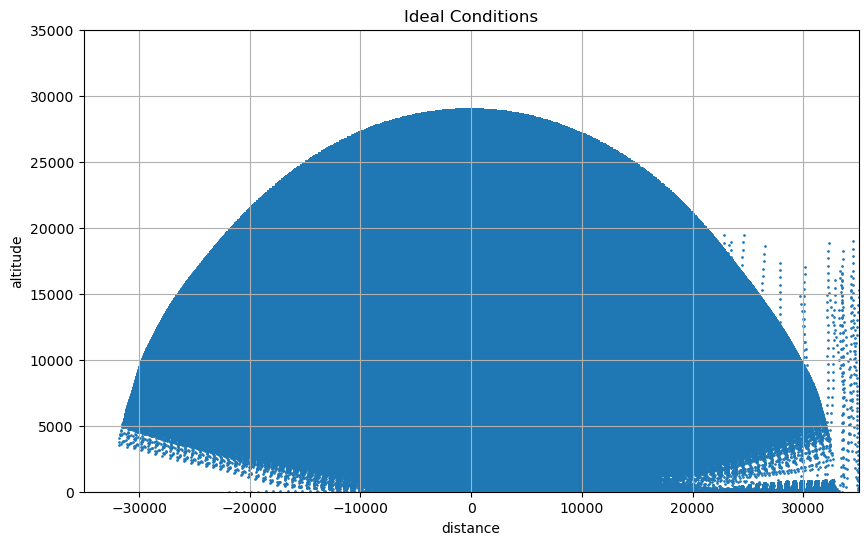

In [41]:
df_ = df

plt.figure(figsize=(10, 6))
plt.scatter(df_['x'],df_['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [43]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/wTemp_wWind_0_cpu_log_low-res.csv')
df

,x,y,z,theta,time,phi
0,0.000000e+00,0.000000e+00,0.000000,-1.130973,0.0,0.000000
1,-3.063532e+02,-1.235468e+01,142.678647,-1.147300,1.0,0.000000
2,-6.155629e+02,-1.142141e+01,282.336680,-1.149111,2.0,0.000000
3,-9.238822e+02,-3.970193e+00,422.686310,-1.141254,3.0,0.000000
4,-1.229024e+03,5.506783e+00,565.969716,-1.128666,4.0,0.000000
...,...,...,...,...,...,...
43645,5.455379e+06,-1.930440e+07,-14593.324439,1041.958568,92.0,2.792527
43646,5.587411e+06,-1.977100e+07,-14807.163749,1059.064186,93.0,2.792527
43647,5.722700e+06,-2.024873e+07,-14668.948451,1080.255937,94.0,2.792527
43648,5.853380e+06,-2.071083e+07,-14587.524137,1088.915912,95.0,2.792527


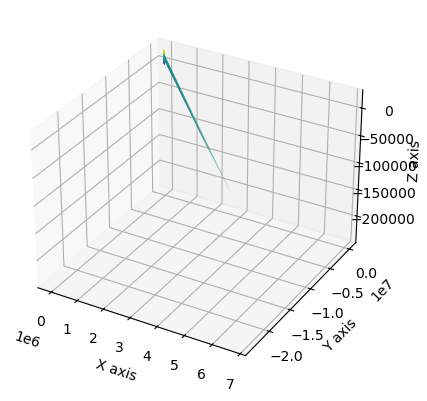

In [46]:

df_ = df[df['time']==90]

x = df_['x'].values
y = df_['y'].values
z = df_['z'].values


xi, yi = np.meshgrid(x, y)

zi = griddata((x, y), z, (xi, yi), method='cubic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi, cmap='viridis')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [3]:
df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/wTemp_wWind_0_cpu_log.csv')
df

,x,y,z,theta,time,phi
0,0.000000e+00,0.000000e+00,0.000000,-1.561820,0.0,0.000000
1,-6.711114e+02,-4.523426e+01,-15.339409,-1.625374,2.0,0.000000
2,-1.336794e+03,-1.034780e+02,-77.489862,-1.701462,4.0,0.000000
3,-1.985221e+03,-1.995073e+02,-200.693040,-1.809401,6.0,0.000000
4,-2.585298e+03,-3.914960e+02,-413.273320,-1.978404,8.0,0.000000
...,...,...,...,...,...,...
30887145,1.881431e+06,-6.666448e+06,-9084.109413,236.698808,88.0,3.141593
30887146,1.954672e+06,-6.924261e+06,-9459.104894,242.581968,90.0,3.141593
30887147,2.032794e+06,-7.199648e+06,-9540.418720,246.375777,92.0,3.141593
30887148,2.114541e+06,-7.490242e+06,-9974.954013,259.554301,94.0,3.141593


In [4]:
group_t = df.groupby('time')

def surface_function(x, y):
    return rbf(x, y)

def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(*args)
    return derivative(wraps, point[var], dx=1e-6)

for t in df['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).to_numpy()
        unique_phi = np.unique(df_[:, 5])
        unique_theta = np.unique(df_[:, 3])
        
        for phi in unique_phi:
            for theta in unique_theta:
                phi_idx = np.where(unique_phi == phi)[0][0]
                theta_idx = np.where(unique_theta == theta)[0][0]
    
                phi_values = unique_phi[max(0, phi_idx-1):min(phi_idx+2, len(unique_phi))]
                theta_values = unique_theta[max(0, theta_idx-1):min(theta_idx+2, len(unique_theta))]
    
                phi_mask = np.isin(df_[:, 5], phi_values)
                theta_mask = np.isin(df_[:, 3], theta_values)
                mask = phi_mask & theta_mask
                
                points = df_[mask]
                
                if points.shape[0] < 1:
                    continue
    
                x = points[:, 0]
                y = points[:, 1]
                z = points[:, 2]
    
                rbf = Rbf(x, y, z, function='thin_plate')
    
                specific_x, specific_y = 2.0, 3.0  
    
                dz_dx = partial_derivative(surface_function, 0, [specific_x, specific_y])
                dz_dy = partial_derivative(surface_function, 1, [specific_x, specific_y])
    
                # Normal vector
                normal = np.array([-dz_dx, -dz_dy, 1])
                normal /= np.linalg.norm(normal)
    
                print("Normal vector at ({}, {}): {}".format(specific_x, specific_y, normal))


Normal vector at (2.0, 3.0): [9.97267645e-01 7.38731608e-02 5.40168327e-07]
Normal vector at (2.0, 3.0): [9.97267645e-01 7.38731608e-02 5.40168327e-07]


/tmp/ipykernel_135359/1167095302.py:11: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(wraps, point[var], dx=1e-6)


ZeroDivisionError: float division by zero

In [69]:
group_t.get_group(20)

,x,y,z,theta,time,phi
20,-5964.649801,48.544968,2981.689792,-1.102435,20.0,0.000000
117,-5767.571785,43.790220,3345.246047,-1.045985,20.0,0.000000
214,-5039.302233,31.322720,4357.032347,-0.852585,20.0,0.000000
311,-6580.008974,80.702563,1271.414177,-1.300280,20.0,0.000000
408,3836.800256,-28179.952538,-3274.404311,-3.128428,20.0,0.000000
...,...,...,...,...,...,...
43185,-4912.143208,-557.465373,-1513.206776,2.890859,20.0,2.792527
43282,-5738.760454,2182.036059,2671.450586,1.136124,20.0,2.792527
43379,8938.779896,-41937.824182,-3836.486800,3.138236,20.0,2.792527
43476,-6083.108904,2350.647551,1603.138595,1.288105,20.0,2.792527


In [84]:
group_t = df.groupby('time')
df_ = group_t.get_group(20).to_numpy()


array([2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 , 2.0943951 ,
       2.0943951 , 2.0943951 , 2.44346095, 2.0943951 , 2.0943951 ,
       2.0943951 , 2.44346095, 2.44346095, 2.44346095, 2.44346095,
       2.44346095, 2.44346095, 2.44346095, 2.44346095, 2.44346095,
       2.44346095, 2.44346095, 2.44346095, 2.44346095, 2.44346095,
       2.44346095, 2.44346095, 2.44346095, 2.44346095, 2.44346095,
       2.44346095, 2.44346095, 2.44346095, 2.44346095, 2.44346

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
from scipy.misc import derivative
from concurrent.futures import ProcessPoolExecutor, as_completed

# Load the data
df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/wTemp_wWind_0_cpu_log.csv')
group_t = df.groupby('time')

def surface_function(x, y):
    return rbf(x, y)

def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(*args)
    return derivative(wraps, point[var], dx=1e-6)

def compute_normal_vector(t):
    results = []
    if t != 0:
        df_ = group_t.get_group(t).to_numpy()
        unique_phi = np.unique(df_[:, 5])
        unique_theta = np.unique(df_[:, 3])
        
        for phi in unique_phi:
            for theta in unique_theta:
                phi_idx = np.where(unique_phi == phi)[0][0]
                theta_idx = np.where(unique_theta == theta)[0][0]
    
                phi_values = unique_phi[max(0, phi_idx-1):min(phi_idx+2, len(unique_phi))]
                theta_values = unique_theta[max(0, theta_idx-1):min(theta_idx+2, len(unique_theta))]
    
                phi_mask = np.isin(df_[:, 5], phi_values)
                theta_mask = np.isin(df_[:, 3], theta_values)
                mask = phi_mask & theta_mask
                
                points = df_[mask]
                
                if points.shape[0] < 1:
                    continue
    
                x = points[:, 0]
                y = points[:, 1]
                z = points[:, 2]
    
                rbf = Rbf(x, y, z, function='thin_plate')
    
                specific_x, specific_y = 2.0, 3.0  
    
                dz_dx = partial_derivative(surface_function, 0, [specific_x, specific_y])
                dz_dy = partial_derivative(surface_function, 1, [specific_x, specific_y])
    
                # Normal vector
                normal = np.array([-dz_dx, -dz_dy, 1])
                normal /= np.linalg.norm(normal)
    
                results.append((specific_x, specific_y, normal))
    
    return results

# Parallel execution
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(compute_normal_vector, t) for t in df['time'].unique()]
    for future in as_completed(futures):
        result = future.result()
        for specific_x, specific_y, normal in result:
            print("Normal vector at ({}, {}): {}".format(specific_x, specific_y, normal))


In [ ]:
import pandas as pd 
import numpy as np

df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/cpp_sim/wTemp_wWind_cpp_alglib_CS_4.csv')

group_t = df.groupby('time')

for t in df['time'].unique():
    df_= group_t.get_group(t)
    df_.to_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/cpp_data/wTemp_wWind_cpp_alglib_CS_4_{t}.csv', index=False)

t_step = df['time'].unique()
np.savetxt('/home/murali/Documents/rass/data/sim_data/dived_data/cpp_data/alglib_CS_4/time_step_cpp_alglib_CS_4.txt', t_step, fmt='%d')

In [3]:
df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/wTemp_wWind_0_cpu_log.csv')
df['time'].unique()

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76.,
       78., 80., 82., 84., 86., 88., 90., 92., 94., 96.])

In [5]:
len(df['phi'].unique()) * len(df['theta'].unique()) * len(df['time'].unique()) 

2662561373241

In [3]:
t_step = df['time'].unique()
np.savetxt('/home/murali/Documents/rass/data/sim_data/dived_data/cpp_data//time_step_cpp_alglib_CS_0.txt', t_step, fmt='%d')

In [19]:
np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76.,
       78., 80., 82., 84., 86., 88., 90., 92., 94., 96.])

In [20]:
df

,x,y,z,theta,time,phi
0,0.000000e+00,0.000000e+00,0.000000,-1.561820,0.0,0.000000
1,-6.711114e+02,-4.523426e+01,-15.339409,-1.625374,2.0,0.000000
2,-1.336794e+03,-1.034780e+02,-77.489862,-1.701462,4.0,0.000000
3,-1.985221e+03,-1.995073e+02,-200.693040,-1.809401,6.0,0.000000
4,-2.585298e+03,-3.914960e+02,-413.273320,-1.978404,8.0,0.000000
...,...,...,...,...,...,...
30887145,1.881431e+06,-6.666448e+06,-9084.109413,236.698808,88.0,3.141593
30887146,1.954672e+06,-6.924261e+06,-9459.104894,242.581968,90.0,3.141593
30887147,2.032794e+06,-7.199648e+06,-9540.418720,246.375777,92.0,3.141593
30887148,2.114541e+06,-7.490242e+06,-9974.954013,259.554301,94.0,3.141593


In [88]:
import numpy as np
import pandas as pd
import itertools
from scipy.interpolate import Rbf
from scipy.misc import derivative

def surface_function(x, y):
    return rbf(x, y)

def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(*args)
    return derivative(wraps, point[var], dx=1e-6)

time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')
rounding_pic = 4
t_step = 84.0 
df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')

if t_step != 0:
    df_ = df.to_numpy()
    df_[:, 5] = np.round(df_[:, 5], decimals=rounding_pic)
    df_[:, 3] = np.round(df_[:, 3], decimals=rounding_pic)
    unique_phi = np.unique(df_[:, 5])
    unique_theta = np.unique(df_[:, 3])
    
    for phi in unique_phi:
        for theta in unique_theta:
            phi_idx = np.where(unique_phi == phi)[0][0]
            theta_idx = np.where(unique_theta == theta)[0][0]

            # Handling wrap-around for phi values
            phi_indices = [(phi_idx-1) % len(unique_phi), phi_idx, (phi_idx+1) % len(unique_phi)]
            phi_values = unique_phi[phi_indices]

            # Handling wrap-around for theta values
            theta_indices = [(theta_idx-1) % len(unique_theta), theta_idx, (theta_idx+1) % len(unique_theta)]
            theta_values = unique_theta[theta_indices]
            
            print('Phi values:', phi_values)
            print('Theta values:', theta_values)

            combinations = list(itertools.product(phi_values, theta_values))
            print(f"Combinations: {combinations}")

            mask = np.array([any((round(row[5], rounding_pic) == round(combo_phi, rounding_pic) and round(row[3], rounding_pic) == round(combo_theta, rounding_pic)) for combo_phi, combo_theta in combinations) for row in df_])
            
            print(f"Mask: {mask}")

            points = df_[mask]
            
            if points.shape[0] < 1:
                print(f"--------------No points found for phi={phi} and theta={theta}-----------------")
                continue

            x = points[:, 0]
            y = points[:, 1]
            z = points[:, 2]

            print(f"x: {x}, y: {y}, z: {z}")

            rbf = Rbf(x, y, z, function='thin_plate')
            mask = (round(row[5], rounding_pic) == round(phi, rounding_pic) and round(row[3], rounding_pic) == round(theta, rounding_pic))
            pts = df_[mask]
            specific_x, specific_y = pts[:,0] , pts[:,1]
            dz_dx = partial_derivative(surface_function, 0, [specific_x, specific_y])
            dz_dy = partial_derivative(surface_function, 1, [specific_x, specific_y])
            normal = np.array([-dz_dx, -dz_dy, 1])
            normal /= np.linalg.norm(normal)
            print("Normal vector at ({}, {}): {}".format(specific_x, specific_y, normal))


Phi values: [3.1416e+00 0.0000e+00 1.7000e-03]
Theta values: [1866.9546 -336.901  -322.8437]
Combinations: [(3.1416, 1866.9546), (3.1416, -336.901), (3.1416, -322.8437), (0.0, 1866.9546), (0.0, -336.901), (0.0, -322.8437), (0.0017, 1866.9546), (0.0017, -336.901), (0.0017, -322.8437)]
Mask: [False False False ... False False False]
--------------No points found for phi=0.0 and theta=-336.901-----------------
Phi values: [3.1416e+00 0.0000e+00 1.7000e-03]
Theta values: [-336.901  -322.8437 -302.7618]
Combinations: [(3.1416, -336.901), (3.1416, -322.8437), (3.1416, -302.7618), (0.0, -336.901), (0.0, -322.8437), (0.0, -302.7618), (0.0017, -336.901), (0.0017, -322.8437), (0.0017, -302.7618)]


KeyboardInterrupt: 

In [89]:
import numpy as np
import pandas as pd
import itertools
from scipy.interpolate import RegularGridInterpolator

# Load time steps
time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')

# Parameters
rounding_pic = 4
t_step = 84.0 

# Load data
df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')

# If t_step is not 0, process data
if t_step != 0:
    df_ = df.to_numpy()
    df_[:, 5] = np.round(df_[:, 5], decimals=rounding_pic)
    df_[:, 3] = np.round(df_[:, 3], decimals=rounding_pic)
    unique_phi = np.unique(df_[:, 5])
    unique_theta = np.unique(df_[:, 3])
    
    for phi in unique_phi:
        for theta in unique_theta:
            phi_idx = np.where(unique_phi == phi)[0][0]
            theta_idx = np.where(unique_theta == theta)[0][0]
            
            phi_indices = [(phi_idx-1) % len(unique_phi), phi_idx, (phi_idx+1) % len(unique_phi)]
            phi_values = unique_phi[phi_indices]

            theta_indices = [(theta_idx-1) % len(unique_theta), theta_idx, (theta_idx+1) % len(unique_theta)]
            theta_values = unique_theta[theta_indices]
            
            print('Phi values:', phi_values)
            print('Theta values:', theta_values)

            combinations = list(itertools.product(phi_values, theta_values))
            print(f"Combinations: {combinations}")

            mask = np.array([any((round(row[5], rounding_pic) == round(combo_phi, rounding_pic) and round(row[3], rounding_pic) == round(combo_theta, rounding_pic)) for combo_phi, combo_theta in combinations) for row in df_])
            
            print(f"Mask: {mask}")

            points = df_[mask]
            
            if points.shape[0] < 1:
                print(f"--------------No points found for phi={phi} and theta={theta}-----------------")
                continue

            x = points[:, 0]
            y = points[:, 1]
            z = points[:, 2]

            print(f"x: {x}, y: {y}, z: {z}")

            # Using RegularGridInterpolator
            interpolator = RegularGridInterpolator((x, y), z)

            specific_point_row = df_[(df_[:, 5] == phi) & (df_[:, 3] == theta)]
            if specific_point_row.shape[0] == 0:
                print(f"No specific point found for phi={phi} and theta={theta}")
                continue
            
            specific_x, specific_y = specific_point_row[0, 0], specific_point_row[0, 1]
            specific_point = np.array([specific_x, specific_y])
            
            dz_dx = (interpolator([specific_point[0] + 1e-5, specific_point[1]]) - interpolator([specific_point[0] - 1e-5, specific_point[1]])) / 2e-5
            dz_dy = (interpolator([specific_point[0], specific_point[1] + 1e-5]) - interpolator([specific_point[0], specific_point[1] - 1e-5])) / 2e-5

            dz_dx = dz_dx.item()
            dz_dy = dz_dy.item()
            gradient = np.array([dz_dx, dz_dy, 1]) 

            point_3d = np.array([specific_point[0], specific_point[1], interpolator(specific_point).item()])

            t = -point_3d[2] / gradient[2]
            intersection = point_3d + t * gradient
            intersection_x, intersection_y = intersection[:2]
            print(f"Intersection at z=0: x={intersection_x}, y={intersection_y}")



Phi values: [3.1416e+00 0.0000e+00 1.7000e-03]
Theta values: [1866.9546 -336.901  -322.8437]
Combinations: [(3.1416, 1866.9546), (3.1416, -336.901), (3.1416, -322.8437), (0.0, 1866.9546), (0.0, -336.901), (0.0, -322.8437), (0.0017, 1866.9546), (0.0017, -336.901), (0.0017, -322.8437)]
Mask: [False False False ... False False False]
--------------No points found for phi=0.0 and theta=-336.901-----------------
Phi values: [3.1416e+00 0.0000e+00 1.7000e-03]
Theta values: [-336.901  -322.8437 -302.7618]
Combinations: [(3.1416, -336.901), (3.1416, -322.8437), (3.1416, -302.7618), (0.0, -336.901), (0.0, -322.8437), (0.0, -302.7618), (0.0017, -336.901), (0.0017, -322.8437), (0.0017, -302.7618)]


KeyboardInterrupt: 

In [95]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, RectBivariateSpline
from scipy.optimize import fsolve

# Define the function to find roots (where z = 0)
def surface_equation(xy):
    x, y = xy
    return interp_surface(x, y)[0]

# Parameters
rounding_pic = 3
t_step = 84.0 

# Load data
time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')
df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')

# Round phi and theta columns
df['phi'] = df['phi'].round(rounding_pic)
df['theta'] = df['theta'].round(rounding_pic)

# Unique values of phi and theta
unique_phi = df['phi'].unique()
unique_theta = df['theta'].unique()

# Iterate over unique combinations of phi and theta
for phi in unique_phi:
    for theta in unique_theta:
       
        
        if points.shape[0] < 9:
            print(f"Not enough points found for phi={phi} and theta={theta}")
            continue
        
        # Extract x, y, z values
        x = points['x'].values
        y = points['y'].values
        z = points['z'].values
        
        # Perform surface interpolation
        grid_x, grid_y = np.meshgrid(np.linspace(min(x), max(x), 100), 
                                     np.linspace(min(y), max(y), 100))
        grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
        
        interp_surface = RectBivariateSpline(np.linspace(min(x), max(x), 100), 
                                             np.linspace(min(y), max(y), 100), 
                                             grid_z)
        
        mask = (df['phi'] == phi) & (df['theta'] == theta)
        point_inst = df[mask]
        
        center_x, center_y = point_inst['x'] , point_inst['y']
        dz_dx = interp_surface(center_x, center_y, dx=1, dy=0)[0, 0]
        dz_dy = interp_surface(center_x, center_y, dx=0, dy=1)[0, 0]
        
        # Compute normal vector
        normal_vector = np.array([-dz_dx, -dz_dy, 1.0])
        normal_vector /= np.linalg.norm(normal_vector)
        
        print(f"Normal vector to the surface at center point ({center_x}, {center_y}):", normal_vector)
        
        # Solve for roots (where z = 0)
        initial_guess = [center_x, center_y]
        roots = fsolve(surface_equation, initial_guess)
        
        print(f"Coordinates (x, y) where z = 0: ({roots[0]}, {roots[1]})")


Phi values: [3.142e+00 0.000e+00 2.000e-03]
Theta values: [ 220.241 -100.253 -106.543]
Combinations: [(3.142, 220.241), (3.142, -100.253), (3.142, -106.543), (0.0, 220.241), (0.0, -100.253), (0.0, -106.543), (0.002, 220.241), (0.002, -100.253), (0.002, -106.543)]
Mask: 0          True
1          True
2         False
3         False
4         False
          ...  
630345    False
630346    False
630347    False
630348    False
630349     True
Length: 630350, dtype: bool
len of the pts: 3
--------------Not enough points found for phi=0.0 and theta=-100.253-----------------
Phi values: [3.142e+00 0.000e+00 2.000e-03]
Theta values: [-100.253 -106.543 -268.55 ]
Combinations: [(3.142, -100.253), (3.142, -106.543), (3.142, -268.55), (0.0, -100.253), (0.0, -106.543), (0.0, -268.55), (0.002, -100.253), (0.002, -106.543), (0.002, -268.55)]
Mask: 0          True
1          True
2          True
3         False
4         False
          ...  
630345    False
630346    False
630347    False
630348  

KeyboardInterrupt: 

In [104]:
unique_phi = df['phi'].unique()
unique_theta = df['theta'].unique()
print(unique_phi[9],unique_theta[31])
print(unique_phi[10],unique_theta[32])
print(unique_phi[11],unique_theta[33])

0.016 -1.113
0.017 -1.18
0.019 -1.193


In [106]:
phi_idx = 10
theta_idx = 32

phi_indices = [(phi_idx-1) % len(unique_phi), phi_idx, (phi_idx+1) % len(unique_phi)]
phi_values = unique_phi[phi_indices]

theta_indices = [(theta_idx-1) % len(unique_theta), theta_idx, (theta_idx+1) % len(unique_theta)]
theta_values = unique_theta[theta_indices]

print('Phi values:', phi_values)
print('Theta values:', theta_values)
combinations = list(itertools.product(phi_values, theta_values))
print(combinations)

Phi values: [0.016 0.017 0.019]
Theta values: [-1.113 -1.18  -1.193]
[(0.016, -1.113), (0.016, -1.18), (0.016, -1.193), (0.017, -1.113), (0.017, -1.18), (0.017, -1.193), (0.019, -1.113), (0.019, -1.18), (0.019, -1.193)]


In [112]:
df[(df['phi'] == combinations[0][0]) & (df['theta'] == combinations[0][1])]

,x,y,z,theta,time,phi


In [123]:
x = (df[df['theta'] == combinations[0][1]]['phi'] == combinations[0][0])
df.iloc[x.index]

,x,y,z,theta,time,phi
31,-25592.129247,-207.980400,9892.028529,-1.113,84.0,0.000
34676,-25161.945785,-4598.152949,9993.625791,-1.113,84.0,0.173
42720,-24957.640856,-5601.394682,10010.310589,-1.113,84.0,0.213
43072,-24944.250991,-5644.632120,10018.237576,-1.113,84.0,0.215
43430,-24931.992877,-5687.976522,10023.709436,-1.113,84.0,0.216
...,...,...,...,...,...,...
194955,-14294.188112,-21071.184904,10473.661297,-1.113,84.0,0.972
621951,26964.629688,-1091.602779,7522.613922,-1.113,84.0,3.101
622299,26971.307186,-1043.971052,7512.929432,-1.113,84.0,3.103
622652,26971.171450,-993.820576,7516.956824,-1.113,84.0,3.105


In [134]:
import numpy as np
import pandas as pd
from scipy.interpolate import RectBivariateSpline, griddata
from scipy.optimize import fsolve

# Function to handle wrap-around index
def wrap_index(idx, total_length):
    return idx % total_length

# Function to define surface equation
def surface_equation(xy):
    x, y = xy
    return interp_surface(x, y)

# Parameters
rounding_pic = 3
t_step = 84.0 

# Load data
time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')
df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')

# Iterate through each row in the DataFrame
for idx, row in df.iterrows():
    phi = row['phi']
    theta = row['theta']
    
    # Initialize array to store 9 points
    points = []
    
    # Current point
    points.append({
        'phi': phi,
        'theta': theta,
        'x': row['x'],
        'y': row['y'],
        'z': row['z']
    })

    # Previous and next points with wrap-around
    for d_phi in [-1, 0, 1]:
        for d_theta in [-1, 0, 1]:
            if d_phi == 0 and d_theta == 0:
                continue 

            idx_phi = wrap_index(idx + d_phi, len(df))
            idx_theta = wrap_index(idx + d_theta, len(df))

            points.append({
                'phi': df.loc[idx_phi, 'phi'],
                'theta': df.loc[idx_theta, 'theta'],
                'x': df.loc[idx_phi, 'x'],
                'y': df.loc[idx_theta, 'y'],
                'z': df.loc[idx_theta, 'z']
            })

    if len(points) < 9:
        print(f"Not enough points found for phi={phi} and theta={theta}")
        continue

    # Convert points list to DataFrame
    points_df = pd.DataFrame(points)
    
    # Interpolate surface
    grid_x, grid_y = np.meshgrid(np.linspace(points_df['x'].min(), points_df['x'].max(), 1000), 
                                 np.linspace(points_df['y'].min(), points_df['y'].max(), 1000))
    grid_z = griddata((points_df['x'], points_df['y']), points_df['z'], (grid_x, grid_y), method='cubic')
    
    interp_surface = RectBivariateSpline(np.linspace(points_df['x'].min(), points_df['x'].max(), 1000), 
                                         np.linspace(points_df['y'].min(), points_df['y'].max(), 1000), 
                                         grid_z)
    
    # Compute normal vector at the center point
    center_x, center_y = points_df.loc[0, 'x'], points_df.loc[0, 'y']
    dz_dx = interp_surface(center_x, center_y, dx=1, dy=0)[0, 0]
    dz_dy = interp_surface(center_x, center_y, dx=0, dy=1)[0, 0]
    
    # Compute normal vector
    normal_vector = np.array([-dz_dx, -dz_dy, 1.0])
    normal_vector /= np.linalg.norm(normal_vector)
    
    print(f"Normal vector to the surface at center point ({center_x}, {center_y}):", normal_vector)
    
    # Solve for roots (where z = 0)
    initial_guess = [center_x, center_y]
    roots = fsolve(surface_equation, initial_guess)
    
    print(f"Coordinates (x, y) where z = 0: ({roots[0]}, {roots[1]})")


Normal vector to the surface at center point (1056471.2822147172, -3746360.613489208): [-1.73915709e-02  5.17052751e-06  9.99848755e-01]


TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'surface_equation'.Shape should be (2,) but it is (1, 1).

In [137]:
import numpy as np
import pandas as pd
from scipy.interpolate import RectBivariateSpline, griddata

# Function to handle wrap-around index
def wrap_index(idx, total_length):
    return idx % total_length

# Parameters
rounding_pic = 3
t_step = 84.0 

# Load data
time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')
df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')

# Function to compute normal vector
def compute_normal_vector(interp_surface, x, y):
    dz_dx = interp_surface(x, y, dx=1, dy=0)[0, 0]
    dz_dy = interp_surface(x, y, dx=0, dy=1)[0, 0]
    normal_vector = np.array([-dz_dx, -dz_dy, 1.0])
    normal_vector /= np.linalg.norm(normal_vector)
    return normal_vector

# Function to find (x, y) where z = 0 along the normal vector
def find_zero_crossing_point(interp_surface, start_x, start_y, normal_vector, step_size=0.1, max_iterations=10000):
    current_x, current_y = start_x, start_y
    iteration = 0
    
    while iteration < max_iterations:
        # Move in the direction of the normal vector
        current_x += normal_vector[0] * step_size
        current_y += normal_vector[1] * step_size
        
        # Evaluate z at the current (x, y)
        current_z = interp_surface(current_x, current_y)[0, 0]
        
        # Check if z crosses zero
        if np.sign(current_z) != np.sign(interp_surface(start_x, start_y)[0, 0]):
            return current_x, current_y
        
        iteration += 1
    
    # If no zero-crossing found within max_iterations, return None
    return None

# Iterate through each row in the DataFrame
for idx, row in df.iterrows():
    phi = row['phi']
    theta = row['theta']
    
    # Initialize array to store 9 points
    points = []
    
    # Current point
    points.append({
        'phi': phi,
        'theta': theta,
        'x': row['x'],
        'y': row['y'],
        'z': row['z']
    })

    # Previous and next points with wrap-around
    for d_phi in [-1, 0, 1]:
        for d_theta in [-1, 0, 1]:
            if d_phi == 0 and d_theta == 0:
                continue 

            idx_phi = wrap_index(idx + d_phi, len(df))
            idx_theta = wrap_index(idx + d_theta, len(df))

            points.append({
                'phi': df.loc[idx_phi, 'phi'],
                'theta': df.loc[idx_theta, 'theta'],
                'x': df.loc[idx_phi, 'x'],
                'y': df.loc[idx_theta, 'y'],
                'z': df.loc[idx_theta, 'z']
            })

    if len(points) < 9:
        print(f"Not enough points found for phi={phi} and theta={theta}")
        continue

    # Convert points list to DataFrame
    points_df = pd.DataFrame(points)
    
    # Interpolate surface
    grid_x, grid_y = np.meshgrid(np.linspace(points_df['x'].min(), points_df['x'].max(), 1000), 
                                 np.linspace(points_df['y'].min(), points_df['y'].max(), 1000))
    grid_z = griddata((points_df['x'], points_df['y']), points_df['z'], (grid_x, grid_y), method='cubic')
    
    interp_surface = RectBivariateSpline(np.linspace(points_df['x'].min(), points_df['x'].max(), 1000), 
                                         np.linspace(points_df['y'].min(), points_df['y'].max(), 1000), 
                                         grid_z)
    
    # Compute normal vector at the center point
    center_x, center_y = points_df.loc[0, 'x'], points_df.loc[0, 'y']
    normal_vector = compute_normal_vector(interp_surface, center_x, center_y)
    
    print(f"Normal vector to the surface at center point ({center_x}, {center_y}):", normal_vector)
    
    # Find (x, y) where z = 0 along the normal vector
    zero_crossing_point = find_zero_crossing_point(interp_surface, center_x, center_y, normal_vector)
    
    if zero_crossing_point is not None:
        print(f"Coordinates (x, y) where z = 0: ({zero_crossing_point[0]}, {zero_crossing_point[1]})")
    else:
        print("No zero-crossing point found within the search limit.")


Normal vector to the surface at center point (1056471.2822147172, -3746360.613489208): [-1.73915709e-02  5.17052751e-06  9.99848755e-01]
No zero-crossing point found within the search limit.
Normal vector to the surface at center point (969127.3996340914, -3434788.46286829): [-1.22693691e-02 -3.36099082e-07  9.99924728e-01]
No zero-crossing point found within the search limit.
Normal vector to the surface at center point (2148748.1568278577, -7626691.526711022): [-8.28562742e-03  3.45945275e-07  9.99965674e-01]
No zero-crossing point found within the search limit.
Normal vector to the surface at center point (703646.0903264915, -2495512.427866227): [4.88877235e-03 2.49863417e-07 9.99988050e-01]
No zero-crossing point found within the search limit.
Normal vector to the surface at center point (1320572.7023811575, -4699774.192360364): [-2.93155787e-02 -2.89405804e-05  9.99570206e-01]
No zero-crossing point found within the search limit.
Normal vector to the surface at center point (15468

KeyboardInterrupt: 

In [2]:
import time

start = time.time()

def wrap_index(idx, total_length):
    return idx % total_length

def compute_normal_vector(interp_surface, x, y):
    dz_dx = interp_surface(x, y, dx=1, dy=0)[0, 0]
    dz_dy = interp_surface(x, y, dx=0, dy=1)[0, 0]
    normal_vector = np.array([-dz_dx, -dz_dy, 1.0])
    normal_vector /= np.linalg.norm(normal_vector)
    return normal_vector

grid_size = 1000
results = []

time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')

for idx, t_step in enumerate(time_steps):
    if t_step!=0:
        print(f"time step: {t_step}, {idx}/{len(time_steps)}")
        df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')
    
    
        for idx, row in df.iterrows():
            phi = row['phi']
            theta = row['theta']
            
            points = []
            
            points.append({
                'phi': phi,
                'theta': theta,
                'x': row['x'],
                'y': row['y'],
                'z': row['z']
            })
        
            for d_phi in [-1, 0, 1]:
                for d_theta in [-1, 0, 1]:
                    if d_phi == 0 and d_theta == 0:
                        continue 
        
                    idx_phi = wrap_index(idx + d_phi, len(df))
                    idx_theta = wrap_index(idx + d_theta, len(df))
        
                    points.append({
                        'phi': df.loc[idx_phi, 'phi'],
                        'theta': df.loc[idx_theta, 'theta'],
                        'x': df.loc[idx_phi, 'x'],
                        'y': df.loc[idx_theta, 'y'],
                        'z': df.loc[idx_theta, 'z']
                    })
                    
            if len(points) < 9:
                print(f"Not enough points found for phi={phi} and theta={theta}")
                continue
        
            points_df = pd.DataFrame(points)
            
            grid_x, grid_y = np.meshgrid(np.linspace(points_df['x'].min(), points_df['x'].max(), grid_size), 
                                         np.linspace(points_df['y'].min(), points_df['y'].max(), grid_size))
            grid_z = griddata((points_df['x'], points_df['y']), points_df['z'], (grid_x, grid_y), method='cubic')
        
            interp_surface = RectBivariateSpline(np.linspace(points_df['x'].min(), points_df['x'].max(), grid_size), 
                                                 np.linspace(points_df['y'].min(), points_df['y'].max(), grid_size), 
                                                 grid_z)
            
            center_x, center_y = points_df.loc[0, 'x'], points_df.loc[0, 'y']
            normal_vector = compute_normal_vector(interp_surface, center_x, center_y)
            nx, ny = normal_vector[:2]
            
            t = -interp_surface(center_x, center_y)[0, 0] / (nx * interp_surface(center_x, center_y, dx=1, dy=0)[0, 0] + ny * interp_surface(center_x, center_y, dx=0, dy=1)[0, 0])
            
            x_zero = center_x + t * nx
            y_zero = center_y + t * ny
            
            if (np.abs(x_zero)<130) & (np.abs(y_zero)<130):
                z_zero = interp_surface(x_zero, y_zero)[0, 0]
                results.append({'x_val': center_x, 'y_val:': center_y, 'x_land': x_zero, 'y_land': y_zero, 'z_land': z_zero, 'time_step': t_step})
                print(f"time_step: {t_step}, Coordinates (x, y) where backscatter at z = 0: ({x_zero}, {y_zero})")

results_df = pd.DataFrame(results)
results_df.to_csv('/home/murali/Documents/rass/data/sim_data/dived_data/backscatter_coordinates.csv', index=False)
end = time.time()

print(f"time taken: {end-start}")

time step: 2.0, 1/49
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (11.570624484137806, 128.06514910621507)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-115.2445432052512, -74.67481389531437)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-67.95967840564231, 103.11836513594017)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-64.09188346130145, 69.89678373348798)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-92.33459247624359, -36.23845379670666)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-102.3730761547576, -0.7074239905770847)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-73.19032672934634, -18.922452277108793)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-39.200912566444686, 15.80362433906316)
time_step: 2.0, Coordinates (x, y) where backscatter at z = 0: (-12.927997767611771, -1.1067623892084522)
time_step: 2.0, Coordinates (x, y) where

KeyboardInterrupt: 

In [ ]:
import time

start = time.time()

def wrap_index(idx, total_length):
    return idx % total_length

def compute_normal_vector(interp_surface, x, y):
    dz_dx = interp_surface(x, y, dx=1, dy=0)[0, 0]
    dz_dy = interp_surface(x, y, dx=0, dy=1)[0, 0]
    normal_vector = np.array([-dz_dx, -dz_dy, 1.0])
    normal_vector /= np.linalg.norm(normal_vector)
    return normal_vector

grid_size = 1000
results = []

time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')

for idx, t_step in enumerate(time_steps):
    if t_step!=0:
        print(f"time step: {t_step}, {idx}/{len(time_steps)}")
        df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')
    
    
        for idx, row in df.iterrows():
            phi = row['phi']
            theta = row['theta']
            
            points = []
            
            points.append({
                'phi': phi,
                'theta': theta,
                'x': row['x'],
                'y': row['y'],
                'z': row['z']
            })
        
            for d_phi in [-1, 0, 1]:
                for d_theta in [-1, 0, 1]:
                    if d_phi == 0 and d_theta == 0:
                        continue 
        
                    idx_phi = wrap_index(idx + d_phi, len(df))
                    idx_theta = wrap_index(idx + d_theta, len(df))
        
                    points.append({
                        'phi': df.loc[idx_phi, 'phi'],
                        'theta': df.loc[idx_theta, 'theta'],
                        'x': df.loc[idx_phi, 'x'],
                        'y': df.loc[idx_theta, 'y'],
                        'z': df.loc[idx_theta, 'z']
                    })
                    
            if len(points) < 9:
                print(f"Not enough points found for phi={phi} and theta={theta}")
                continue
        
            points_df = pd.DataFrame(points)
            
            grid_x, grid_y = np.meshgrid(np.linspace(points_df['x'].min(), points_df['x'].max(), grid_size), 
                                         np.linspace(points_df['y'].min(), points_df['y'].max(), grid_size))
            grid_z = griddata((points_df['x'], points_df['y']), points_df['z'], (grid_x, grid_y), method='cubic')
        
            interp_surface = RectBivariateSpline(np.linspace(points_df['x'].min(), points_df['x'].max(), grid_size), 
                                                 np.linspace(points_df['y'].min(), points_df['y'].max(), grid_size), 
                                                 grid_z)
            
            center_x, center_y = points_df.loc[0, 'x'], points_df.loc[0, 'y']
            normal_vector = compute_normal_vector(interp_surface, center_x, center_y)
            nx, ny = normal_vector[:2]
            
            t = -interp_surface(center_x, center_y)[0, 0] / (nx * interp_surface(center_x, center_y, dx=1, dy=0)[0, 0] + ny * interp_surface(center_x, center_y, dx=0, dy=1)[0, 0])
            
            x_zero = center_x + t * nx
            y_zero = center_y + t * ny
            
            if (np.abs(x_zero)<130) & (np.abs(y_zero)<130):
                result = {'x_val': center_x, 'y_val': center_y, 'z_val': center_z, 'x_land': x_zero, 'y_land': y_zero, 'time_step': t_step}
                writer.writerow(result)
                print(f"time_step: {t_step}, Coordinates (x, y) where backscatter at z = 0: ({x_zero}, {y_zero})")

end = time.time()

print(f"time taken: {end-start}")

In [126]:
df0 = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp.csv')
df0 = df0[df0['phi'] != 0].reset_index(drop=True)
df0

,x,y,z,theta,time,phi
0,0.00000,0.000,0.000000e+00,-1.57080,0,1.5708
1,1.90544,-331.434,2.082450e-14,-1.57080,1,1.5708
2,3.81088,-662.867,4.164890e-14,-1.57080,2,1.5708
3,5.71633,-994.301,6.247340e-14,-1.57080,3,1.5708
4,7.62177,-1325.730,8.329790e-14,-1.57080,4,1.5708
...,...,...,...,...,...,...
33945,175.30100,32083.300,2.808390e+02,1.56182,92,1.5708
33946,177.20600,32432.000,2.838910e+02,1.56182,93,1.5708
33947,179.11200,32780.800,2.869440e+02,1.56182,94,1.5708
33948,181.01700,33129.500,2.899960e+02,1.56182,95,1.5708


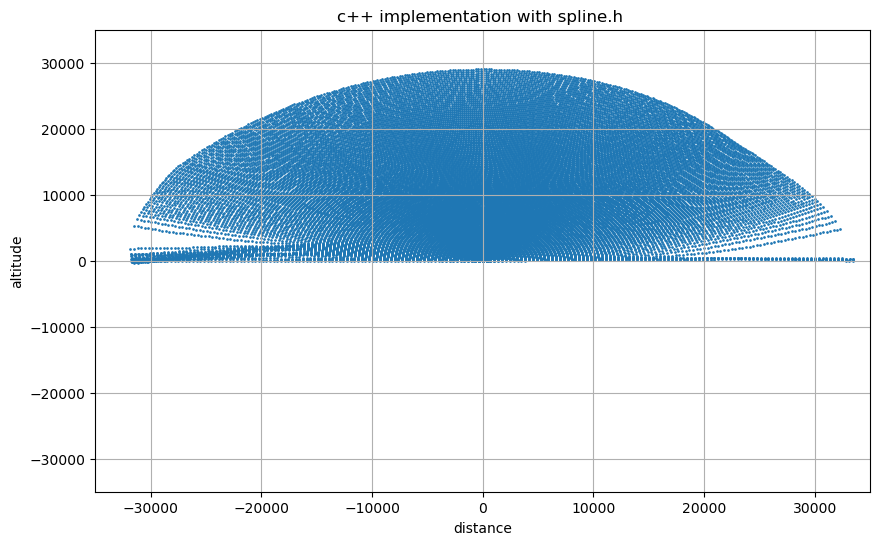

In [127]:
plt.figure(figsize=(10, 6))
plt.scatter(df0['y'],df0['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
plt.title("c++ implementation with spline.h ")
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [138]:
df0['time'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

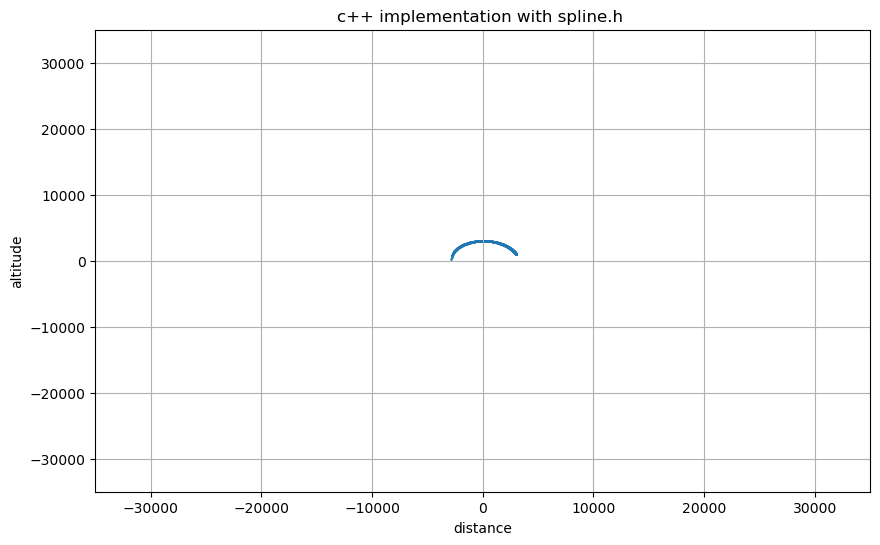

In [148]:
df0 = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib.csv')
df0 = df0[df0['phi'] != 0].reset_index(drop=True)

t = 9
df0 = df0.groupby('time').get_group(t)

df0 = df0[df0['z'] >= 0]

plt.figure(figsize=(10, 6))
plt.scatter(df0['y'],df0['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
plt.title("c++ implementation with spline.h ")
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [130]:
dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib.csv')
dfa

,x,y,z,theta,time,phi
0,0.00000,0.0000,0.0000,-1.570800,0,0.0000
1,-255.37400,78.8238,-63.5554,-2.008110,1,0.0000
2,-385.44100,226.9440,-226.3100,-2.519450,2,0.0000
3,-311.55400,521.4920,-407.5830,-2.950220,3,0.0000
4,-6.89344,1257.1900,-747.7170,-3.073810,4,0.0000
...,...,...,...,...,...,...
67895,-223.22800,23181.0000,15889.1000,0.811106,92,1.5708
67896,-228.52900,23377.3000,16080.3000,0.811110,93,1.5708
67897,-232.11600,23573.5000,16271.2000,0.808868,94,1.5708
67898,-232.84900,23768.1000,16462.6000,0.804442,95,1.5708


In [131]:
dfa['phi'].unique(), dfa['time'].unique()

(array([0.    , 1.5708]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]))

In [132]:
dfa = dfa[dfa['phi'] != 0].reset_index(drop=True)
dfa

,x,y,z,theta,time,phi
0,0.0000,0.000,0.0000,-1.570800,0,1.5708
1,40.7829,-197.085,-90.5511,-2.197230,1,1.5708
2,129.1050,-161.074,-277.5530,-2.764370,2,1.5708
3,291.1640,141.825,-424.9490,-3.177250,3,1.5708
4,656.4710,926.561,-767.8400,-3.155660,4,1.5708
...,...,...,...,...,...,...
33945,-223.2280,23181.000,15889.1000,0.811106,92,1.5708
33946,-228.5290,23377.300,16080.3000,0.811110,93,1.5708
33947,-232.1160,23573.500,16271.2000,0.808868,94,1.5708
33948,-232.8490,23768.100,16462.6000,0.804442,95,1.5708


In [133]:
dfa.describe()

,x,y,z,theta,time,phi
count,3.395000e+04,3.395000e+04,33950.000000,33950.000000,33950.000000,3.395000e+04
mean,4.592334e+04,1.072426e+05,9686.623663,-41.752062,48.000000,1.570800e+00
std,1.592855e+05,3.639879e+05,8103.544864,142.010749,28.000412,8.735363e-13
min,-3.411850e+02,-3.091550e+04,-5998.830000,-1540.940000,0.000000,1.570800e+00
25%,-1.757685e+02,-7.175788e+02,2927.262500,-1.085210,24.000000,1.570800e+00
50%,3.020080e+01,5.400485e+03,9197.070000,-0.004022,48.000000,1.570800e+00
75%,1.324250e+02,1.780492e+04,15817.975000,0.630134,72.000000,1.570800e+00
max,2.084960e+06,4.806200e+06,28975.800000,1.561820,96.000000,1.570800e+00


In [112]:
dfa.drop_duplicates(subset=['y','z'], inplace=True)

,x,y,z,theta,time,phi
0,0.000000e+00,0.000000e+00,0.000000e+00,-1.57080,0,1.5708
1,2.072850e+00,-3.494540e+02,1.236830e+01,-1.49913,1,1.5708
2,3.985170e+00,-6.954940e+02,4.873120e+01,-1.43120,2,1.5708
3,5.643110e+00,-1.035390e+03,1.069910e+02,-1.37030,3,1.5708
4,7.068670e+00,-1.367550e+03,1.840170e+02,-1.31892,4,1.5708
...,...,...,...,...,...,...
33945,1.118240e+08,-3.804190e+08,-9.679800e+05,3.14032,92,1.5708
33946,1.287310e+08,-4.378980e+08,-1.038540e+06,3.14041,93,1.5708
33947,1.481910e+08,-5.040560e+08,-1.114240e+06,3.14049,94,1.5708
33948,1.705910e+08,-5.802060e+08,-1.195450e+06,3.14056,95,1.5708


In [116]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33950 entries, 0 to 33949
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       33950 non-null  float64
 1   y       33950 non-null  float64
 2   z       33950 non-null  float64
 3   theta   33950 non-null  float64
 4   time    33950 non-null  int64  
 5   phi     33950 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.6 MB


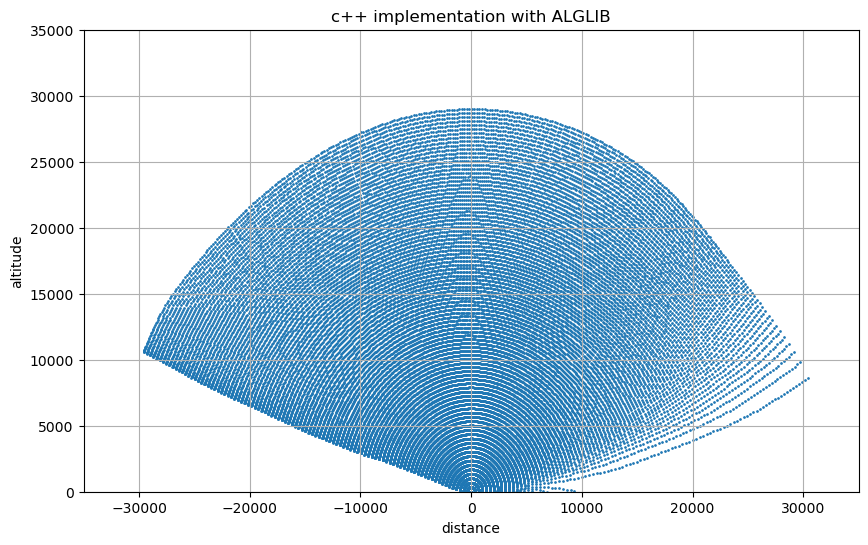

In [91]:
plt.figure(figsize=(10, 6))
plt.scatter(dfa['y'],dfa['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title("c++ implementation with ALGLIB")
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [59]:
df1 = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWindpp.csv')
df1 = df1[df1['phi'] != 0].reset_index(drop=True)
df1

,x,y,z,theta,time,phi
0,0.000000e+00,0.000000e+00,0.000000,-1.570796,0.0,1.570796
1,6.259217e+00,-3.615627e+02,26.891817,-1.416091,1.0,1.570796
2,1.100705e+01,-7.086212e+02,101.797192,-1.290029,2.0,1.570796
3,1.387181e+01,-1.035589e+03,211.417016,-1.204893,3.0,1.570796
4,1.567420e+01,-1.345967e+03,341.712520,-1.157789,4.0,1.570796
...,...,...,...,...,...,...
33945,5.899295e+06,-2.086537e+07,-13762.669885,1681.343749,92.0,1.570796
33946,6.011707e+06,-2.126278e+07,-13994.013021,1719.646560,93.0,1.570796
33947,6.127564e+06,-2.167272e+07,-14038.548825,1755.038897,94.0,1.570796
33948,6.244999e+06,-2.208778e+07,-14164.479176,1817.067157,95.0,1.570796


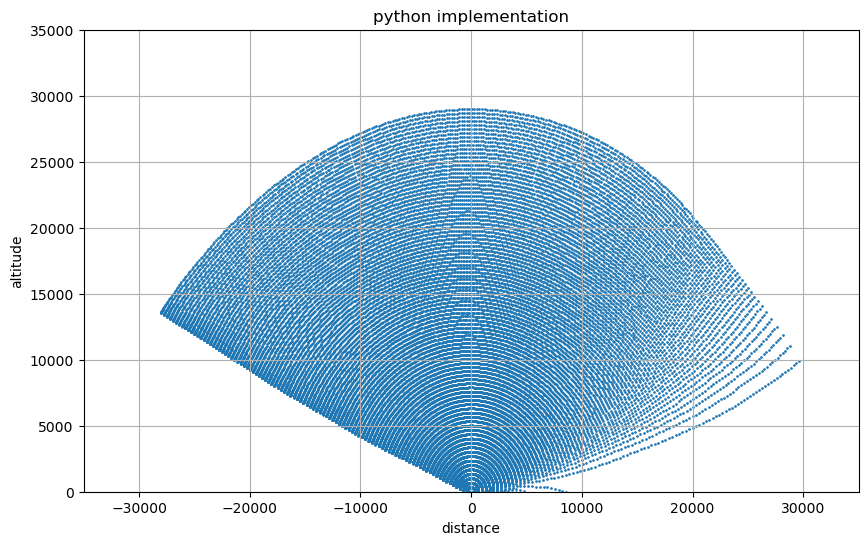

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(df1['y'],df1['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title("python implementation")
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [61]:
from scipy.interpolate import CubicSpline

ValueError: `x` must be strictly increasing sequence.

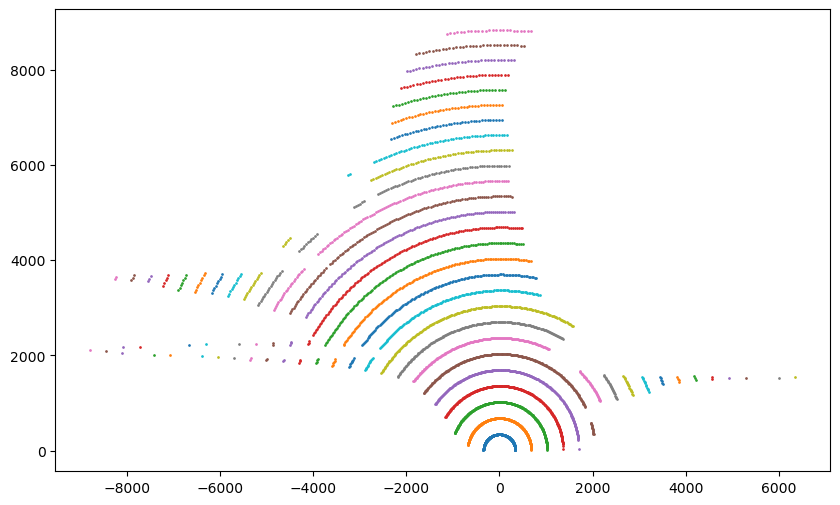

In [20]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp.csv')

group_t = df.groupby('time')

plt.figure(figsize=(10, 6))

for t in df['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).sort_values('x')
        
        wave_eq = CubicSpline(df_['x'],df_['z'])
        
        x_l = []
        y_l = []
        for x0 in df_['x'].to_numpy():
            
            dz_dx = wave_eq.derivative()(x0)
        
            land_x = x0 + wave_eq(x0) * dz_dx
            if np.abs(land_x) < 50:
                x_l.append(x0)
                y_l.append(wave_eq(x0))
        
        
        plt.scatter(x_l,y_l, s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.xlabel('x')
plt.ylabel('z')
plt.title('N-S c++')
plt.grid()
plt.show()

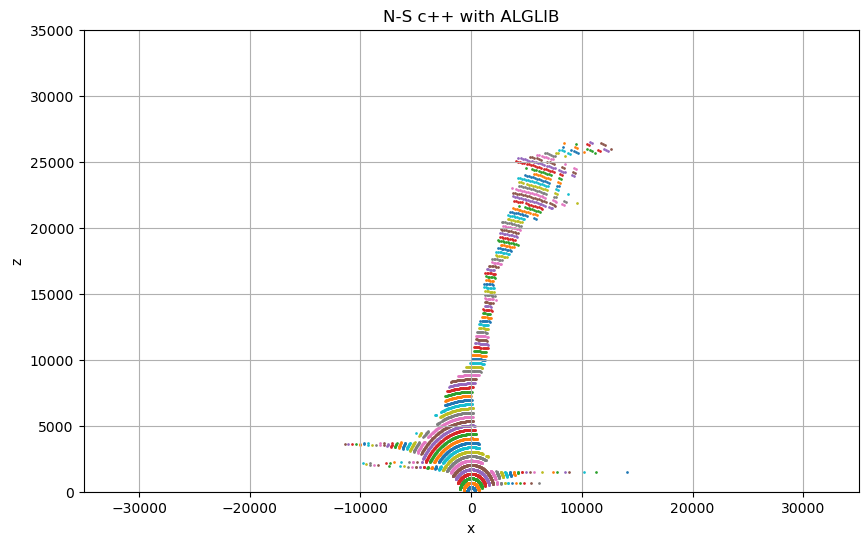

In [21]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib.csv')

group_t = df.groupby('time')

plt.figure(figsize=(10, 6))

for t in df['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).sort_values('x')
        
        wave_eq = CubicSpline(df_['x'],df_['z'])
        
        x_l = []
        y_l = []
        for x0 in df_['x'].to_numpy():
            
            dz_dx = wave_eq.derivative()(x0)
        
            land_x = x0 + wave_eq(x0) * dz_dx
            if np.abs(land_x) < 50:
                x_l.append(x0)
                y_l.append(wave_eq(x0))
        
        
        plt.scatter(x_l,y_l, s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.xlabel('x')
plt.ylabel('z')
plt.title('N-S c++ with ALGLIB')
plt.grid()
plt.show()

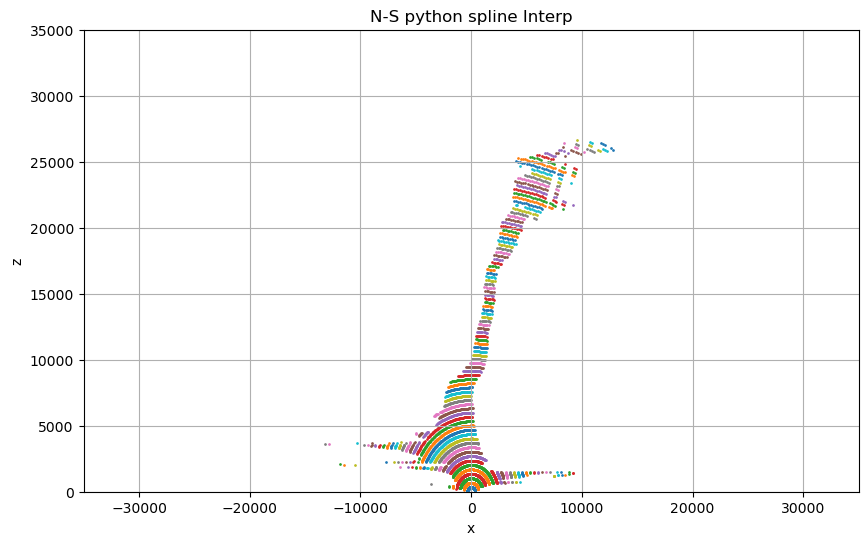

In [154]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWindpp.csv')
df = df[df['z']>=0]

group_t = df.groupby('time')

plt.figure(figsize=(10, 6))

for t in df['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).sort_values('x')
        
        wave_eq = CubicSpline(df_['x'],df_['z'])
        
        x_l = []
        y_l = []
        for x0 in df_['x'].to_numpy():
            
            dz_dx = wave_eq.derivative()(x0)
        
            land_x = x0 + wave_eq(x0) * dz_dx
            if np.abs(land_x) < 50:
                x_l.append(x0)
                y_l.append(wave_eq(x0))
        
        plt.scatter(x_l,y_l, s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.xlabel('x')
plt.ylabel('z')
plt.title('N-S python spline Interp')
plt.grid()
plt.show()

In [155]:
dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp.csv')
dfa = dfa[dfa['phi'] != 0].reset_index(drop=True)
dfa = dfa[dfa['z']>=0]

group_t = dfa.groupby('time')

plt.figure(figsize=(10, 6))

for t in df['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t)
        # df_.drop_duplicates(subset=['y'], inplace=True)
        # df_.dropna(subset=['y', 'z'], inplace=True)
        
        df_.sort_values('y',inplace=True)
        
        wave_eq = CubicSpline(df_['y'],df_['z'])
        
        x_l = []
        y_l = []
        for x0 in df_['y'].to_numpy():
            
            dz_dx = wave_eq.derivative()(x0)
        
            land_x = x0 + wave_eq(x0) * dz_dx
            if np.abs(land_x) < 50:
                x_l.append(x0)
                y_l.append(wave_eq(x0))
        
        
        plt.scatter(x_l,y_l, s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.xlabel('x')
plt.ylabel('z')
plt.title('E-W in c++ with spline.h ')
plt.grid()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp.csv'

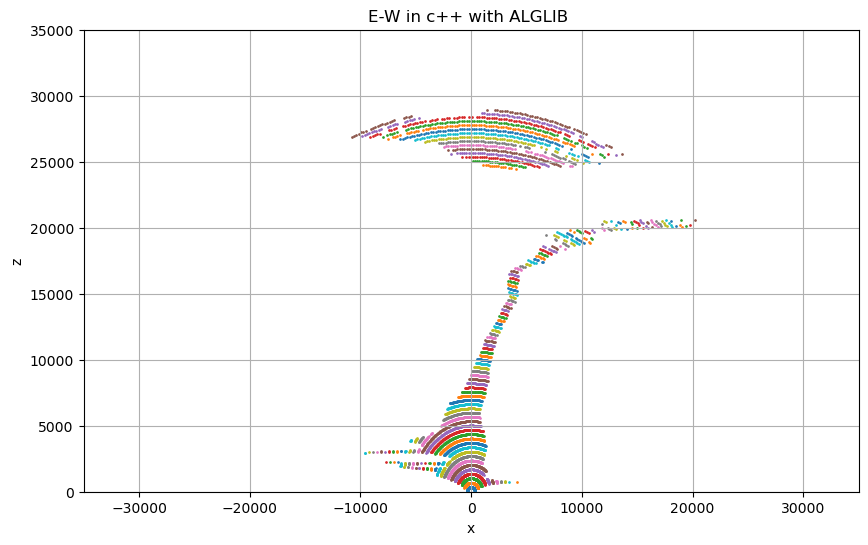

In [204]:
dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib.csv')
dfa = dfa[dfa['phi'] != 0].reset_index(drop=True)
dfa = dfa[dfa['z']>=0]
dfa = dfa[(dfa['theta'] <= np.pi/2) & (dfa['theta']>= -np.pi/2)]
dfa = dfa[(dfa['theta'] <= np.pi/2) & (dfa['phi']>= 0)]

group_t = dfa.groupby('time')

plt.figure(figsize=(10, 6))

for t in dfa['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).sort_values('y')
        df_ = df_.drop_duplicates(subset='y')
        
        wave_eq = CubicSpline(df_['y'],df_['z'])
        
        x_l = []
        y_l = []
        for x0 in df_['y'].to_numpy():
            
            dz_dx = wave_eq.derivative()(x0)
        
            land_x = x0 + wave_eq(x0) * dz_dx
            if np.abs(land_x) < 50:
                x_l.append(x0)
                y_l.append(wave_eq(x0))
        
        
        plt.scatter(x_l,y_l, s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.xlabel('x')
plt.ylabel('z')
plt.title('E-W in c++ with ALGLIB ')
plt.grid()
plt.show()

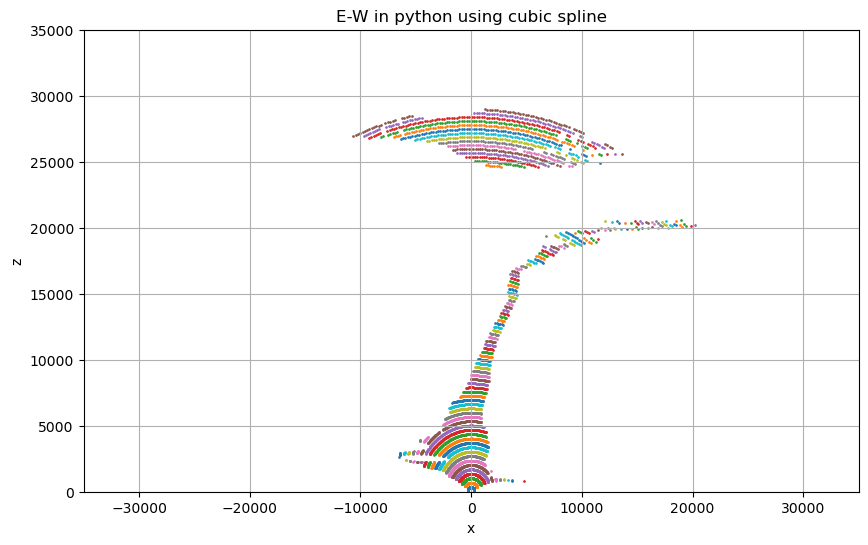

In [205]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWindpp.csv')
df = df[df['phi'] != 0].reset_index(drop=True)
df = df[df['z']>=0]
df = df[(df['theta'] <= np.pi/2) & (df['theta']>= -np.pi/2)]

group_t = df.groupby('time')

plt.figure(figsize=(10, 6))

for t in df['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).sort_values('y')
        # df_ = df_.drop_duplicates(subset='y')
        
        wave_eq = CubicSpline(df_['y'],df_['z'])
        
        x_l = []
        y_l = []
        for x0 in df_['y'].to_numpy():
            
            dz_dx = wave_eq.derivative()(x0)
        
            land_x = x0 + wave_eq(x0) * dz_dx
            if np.abs(land_x) < 50:
                x_l.append(x0)
                y_l.append(wave_eq(x0))
        
        plt.scatter(x_l,y_l, s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.xlabel('x')
plt.ylabel('z')
plt.title('E-W in python using cubic spline')
plt.grid()
plt.show()

In [200]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWindpp.csv')
df = df[df['phi'] != 0].reset_index(drop=True)
df = df[df['z']>=0]
df = df[(df['theta'] <= np.pi/2) & (df['theta']>= -np.pi/2)]

,x,y,z,theta,time,phi
0,0.000000,0.000000,0.000000,-1.570796,0.0,1.570796
97,0.000000,0.000000,0.000000,-1.561820,0.0,1.570796
194,0.000000,0.000000,0.000000,-1.552844,0.0,1.570796
291,0.000000,0.000000,0.000000,-1.543868,0.0,1.570796
388,0.000000,0.000000,0.000000,-1.534892,0.0,1.570796
...,...,...,...,...,...,...
33945,-117.722618,26681.194943,11967.554261,0.866865,92.0,1.570796
33946,-125.927176,26877.599858,12156.494448,0.865655,93.0,1.570796
33947,-138.118632,27073.092066,12345.729453,0.860780,94.0,1.570796
33948,-151.587451,27264.610913,12536.424189,0.850435,95.0,1.570796


In [206]:
# Load Python-generated data
df_py = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWindpp.csv')
df_py = df_py[df_py['phi'] != 0].reset_index(drop=True)
df_py = df_py[df_py['z'] >= 0]

# Load C++ generated data
df_cpp = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib.csv')
df_cpp = df_cpp[df_cpp['phi'] != 0].reset_index(drop=True)
df_cpp = df_cpp[df_cpp['z'] >= 0]

# Compare basic statistics
print("Python Data Statistics")
print(df_py.describe())
print("\nC++ Data Statistics")
print(df_cpp.describe())


Python Data Statistics
                  x             y             z         theta          time  \
count  2.990700e+04  2.990700e+04  29907.000000  29907.000000  29907.000000   
mean   6.849683e+02 -4.630148e+03  11410.469670     -0.068284     47.706289   
std    3.674206e+04  1.304304e+05   7374.358759      2.454646     28.154999   
min   -3.532653e+02 -6.238858e+06      0.000000     -1.570796      0.000000   
25%   -2.015083e+02 -8.729870e+03   5184.963879     -0.715240     23.000000   
50%   -9.001929e+01 -1.192550e+03  10819.004283     -0.166131     48.000000   
75%    4.705083e+01  4.364010e+03  16871.991356      0.449114     72.000000   
max    1.762571e+06  2.960276e+04  28986.953991    113.004829     96.000000   

                phi  
count  2.990700e+04  
mean   1.570796e+00  
std    5.098229e-13  
min    1.570796e+00  
25%    1.570796e+00  
50%    1.570796e+00  
75%    1.570796e+00  
max    1.570796e+00  

C++ Data Statistics
                  x             y             

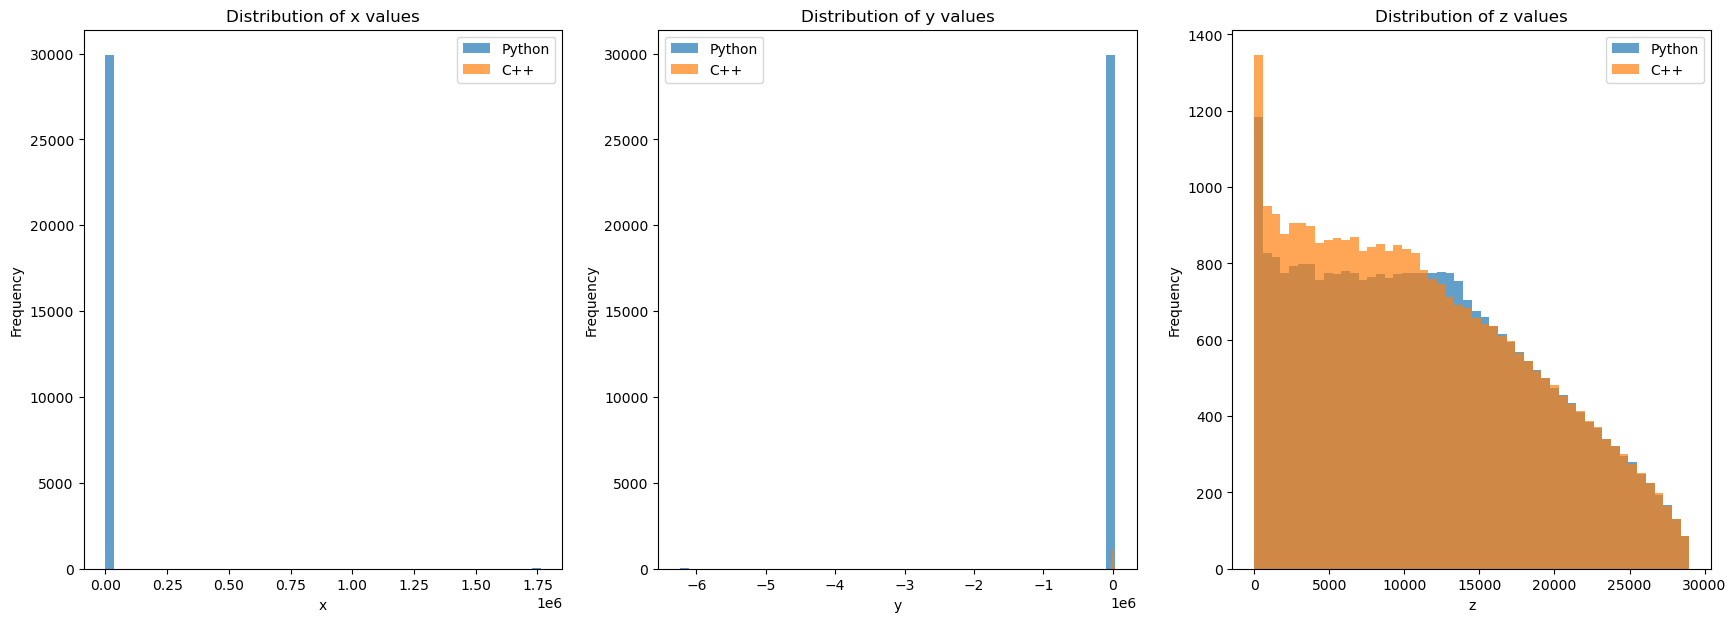

In [207]:
import matplotlib.pyplot as plt

# Plot comparison for 'y' values
plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.hist(df_py['x'], bins=50, alpha=0.7, label='Python')
plt.hist(df_cpp['x'], bins=50, alpha=0.7, label='C++')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Distribution of x values')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(df_py['y'], bins=50, alpha=0.7, label='Python')
plt.hist(df_cpp['y'], bins=50, alpha=0.7, label='C++')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('Distribution of y values')
plt.legend()

# Plot comparison for 'z' values
plt.subplot(1, 3, 3)
plt.hist(df_py['z'], bins=50, alpha=0.7, label='Python')
plt.hist(df_cpp['z'], bins=50, alpha=0.7, label='C++')
plt.xlabel('z')
plt.ylabel('Frequency')
plt.title('Distribution of z values')
plt.legend()

plt.show()


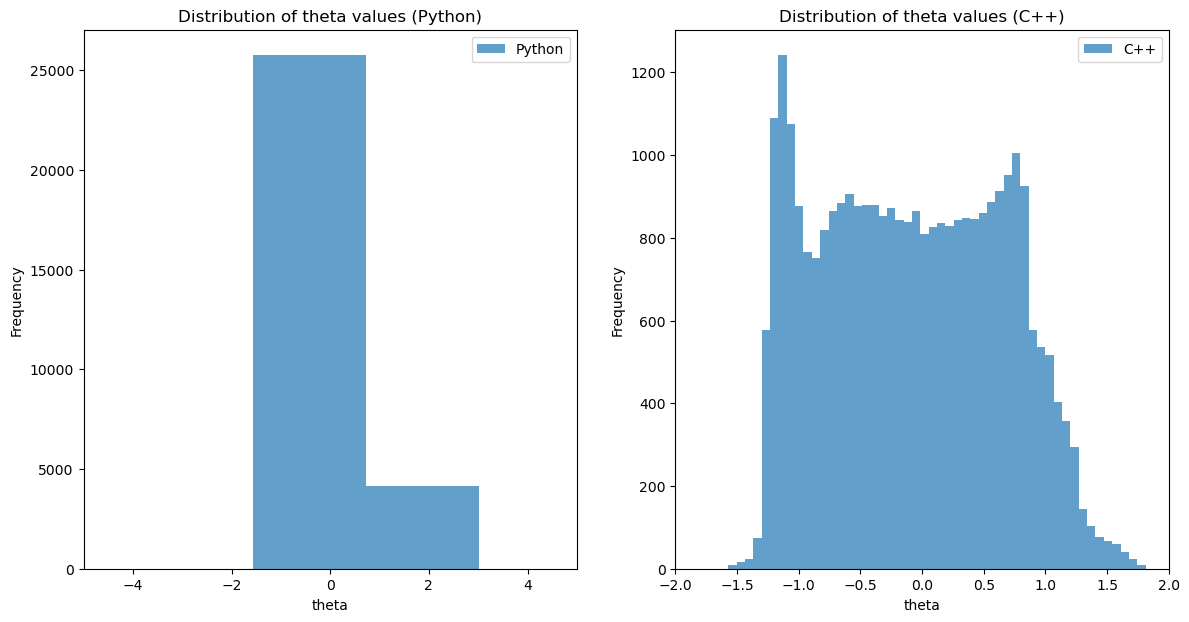

In [218]:
plt.figure(figsize=(14, 7))

# Plot histogram for Python data
plt.subplot(1, 2, 1)
plt.hist(df_py['theta'], bins=50, alpha=0.7, label='Python')
plt.xlabel('theta')
plt.ylabel('Frequency')
plt.title('Distribution of theta values (Python)')
theta = 5
plt.xlim((-theta,theta))
plt.legend()

# Plot histogram for C++ data
plt.subplot(1, 2, 2)
plt.hist(df_cpp['theta'], bins=50, alpha=0.7, label='C++')
plt.xlabel('theta')
plt.ylabel('Frequency')
plt.title('Distribution of theta values (C++)')
plt.legend()

theta = 2
plt.xlim((-theta,theta))

plt.show()


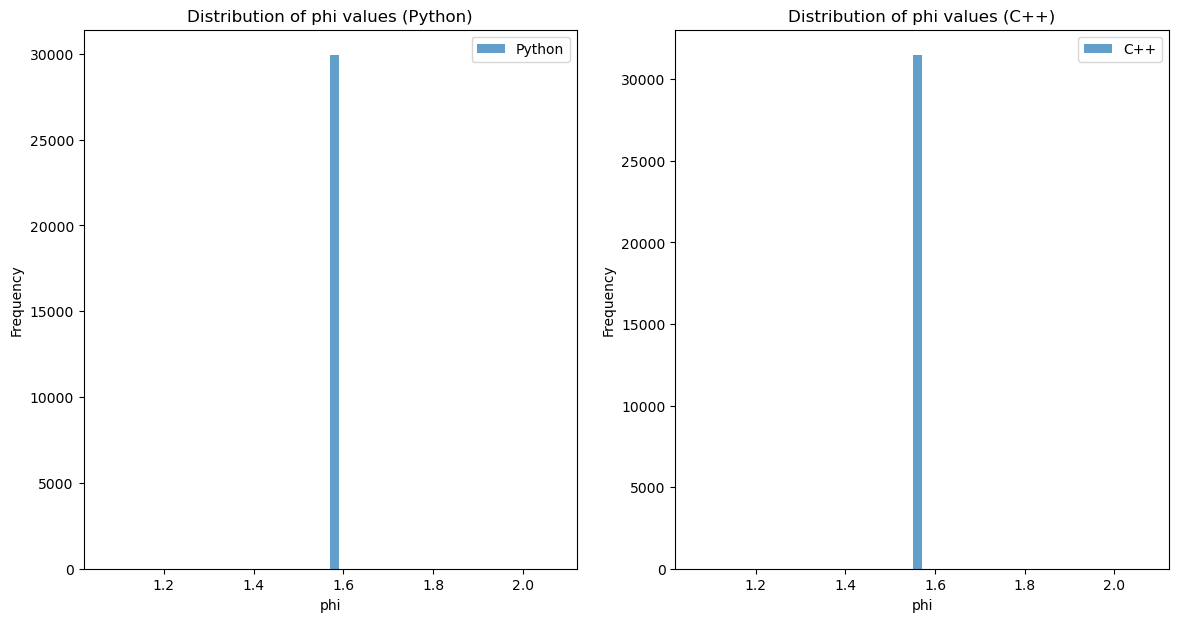

In [220]:
plt.figure(figsize=(14, 7))

# Plot histogram for Python data
plt.subplot(1, 2, 1)
plt.hist(df_py['phi'], bins=50, alpha=0.7, label='Python')
plt.xlabel('phi')
plt.ylabel('Frequency')
plt.title('Distribution of phi values (Python)')
plt.legend()

# Plot histogram for C++ data
plt.subplot(1, 2, 2)
plt.hist(df_cpp['phi'], bins=50, alpha=0.7, label='C++')
plt.xlabel('phi')
plt.ylabel('Frequency')
plt.title('Distribution of phi values (C++)')
plt.legend()

plt.show()


Python Data Slice
                x             y             z     theta  time       phi
80    -139.743468 -23620.689946  11175.884837 -1.034569  80.0  1.570796
177   -140.516416 -23614.077597  11187.003048 -1.034108  80.0  1.570796
274   -141.398094 -23604.920499  11202.379600 -1.033355  80.0  1.570796
371   -142.391248 -23593.518007  11221.489382 -1.032405  80.0  1.570796
468   -143.432003 -23581.009147  11242.407078 -1.031406  80.0  1.570796
...           ...           ...           ...       ...   ...       ...
29277  -30.716124  23818.394238  10110.116840  0.943447  80.0  1.570796
29374   16.244398  24171.351531   9608.089607  0.978181  80.0  1.570796
29471   78.809913  24531.734720   9048.116649  1.021858  80.0  1.570796
29568  159.471144  24931.452179   8369.928597  1.044589  80.0  1.570796
29665  223.965668  25479.375058   7396.955905  1.075523  80.0  1.570796

[306 rows x 6 columns]

C++ Data Slice
              x        y        z    theta  time     phi
80      94.3225 -2497

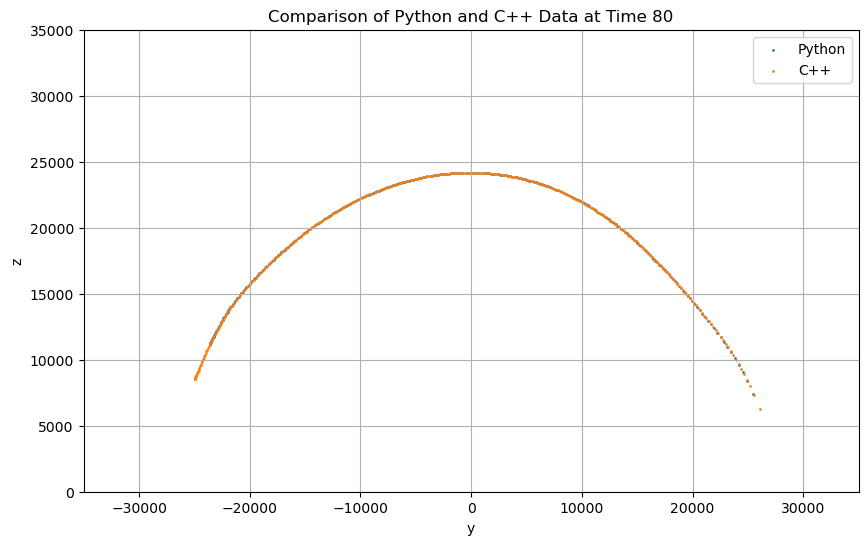

In [222]:
# Example: Inspect time slice 1
time_slice = 80

df_py_slice = df_py[df_py['time'] == time_slice].sort_values('y')
df_cpp_slice = df_cpp[df_cpp['time'] == time_slice].sort_values('y')

print("Python Data Slice")
print(df_py_slice)
print("\nC++ Data Slice")
print(df_cpp_slice)

print("\nPython Data Statistics")
print(df_py_slice.describe())
print("\nc++ Data Statistics")
print(df_cpp_slice.describe())

print("\n")
# Plot comparison for the time slice
plt.figure(figsize=(10, 6))

plt.scatter(df_py_slice['y'], df_py_slice['z'], label='Python', s=0.9)
plt.scatter(df_cpp_slice['y'], df_cpp_slice['z'], label='C++',s=0.9)
plt.xlabel('y')
plt.ylabel('z')

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))

plt.title(f'Comparison of Python and C++ Data at Time {time_slice}')
plt.legend()
plt.grid()
plt.show()


In [2]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_0.csv')
df

,x,y,z,theta,time,phi
0,0.0000,0.00000,0.0000,-1.570800e+00,0,0.00000
1,-188.5670,0.91130,40.2251,-3.430830e+07,1,0.00000
2,-16.8491,3.89917,153.5240,-3.430830e+07,2,0.00000
3,238.7680,8.45366,140.4180,-3.430830e+07,3,0.00000
4,381.8500,10.92380,24.7432,-3.430830e+07,4,0.00000
...,...,...,...,...,...,...
305545,2746.6000,-20249.10000,-2408.1100,2.023670e+00,92,2.79253
305546,2775.9400,-20485.50000,-2408.1100,2.023670e+00,93,2.79253
305547,2805.2700,-20721.80000,-2408.1100,2.023670e+00,94,2.79253
305548,2834.6100,-20958.20000,-2408.1100,2.023670e+00,95,2.79253


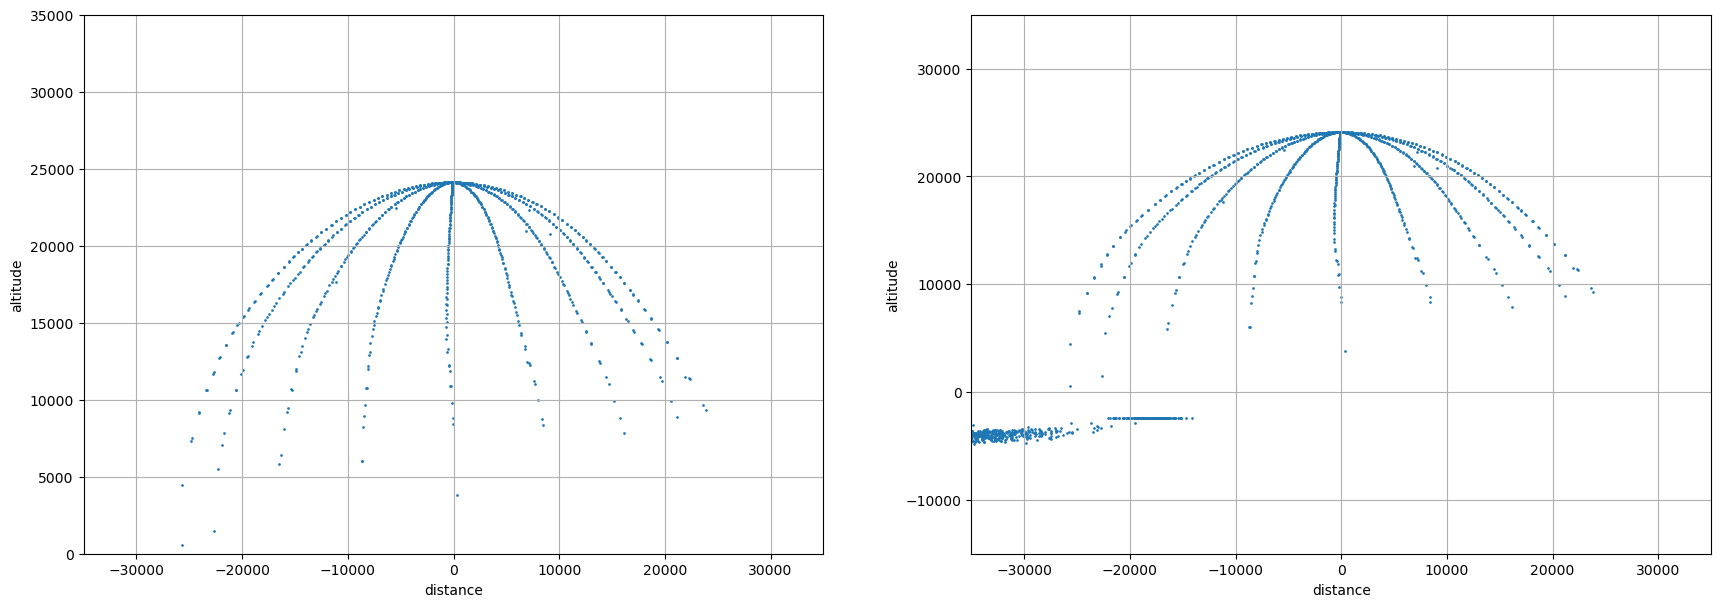

In [5]:
t_slice = 80

group_t = df.groupby('time')
df_t = group_t.get_group(t_slice)
df_t

plt.figure(figsize=(21, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-15 * 1000,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

In [14]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_0.csv')
df

,x,y,z,theta,time,phi
0,0.0000,0.000000e+00,0.000000e+00,-1.57080,0,0.00000
1,-57.1666,4.510740e-33,3.500440e-15,-2.27332,1,0.00000
2,-57.1666,5.141960e-33,1.079420e-15,-2.88726,2,0.00000
3,-57.1666,5.199470e-33,2.893470e-16,-3.07692,3,0.00000
4,-57.1666,5.203630e-33,7.195370e-17,-3.12557,4,0.00000
...,...,...,...,...,...,...
12255945,-58.1269,1.117630e-04,4.277450e-56,3.14159,92,3.14159
12255946,-58.1269,1.117630e-04,1.057840e-56,3.14159,93,3.14159
12255947,-58.1269,1.117630e-04,2.616100e-57,3.14159,94,3.14159
12255948,-58.1269,1.117630e-04,6.469780e-58,3.14159,95,3.14159


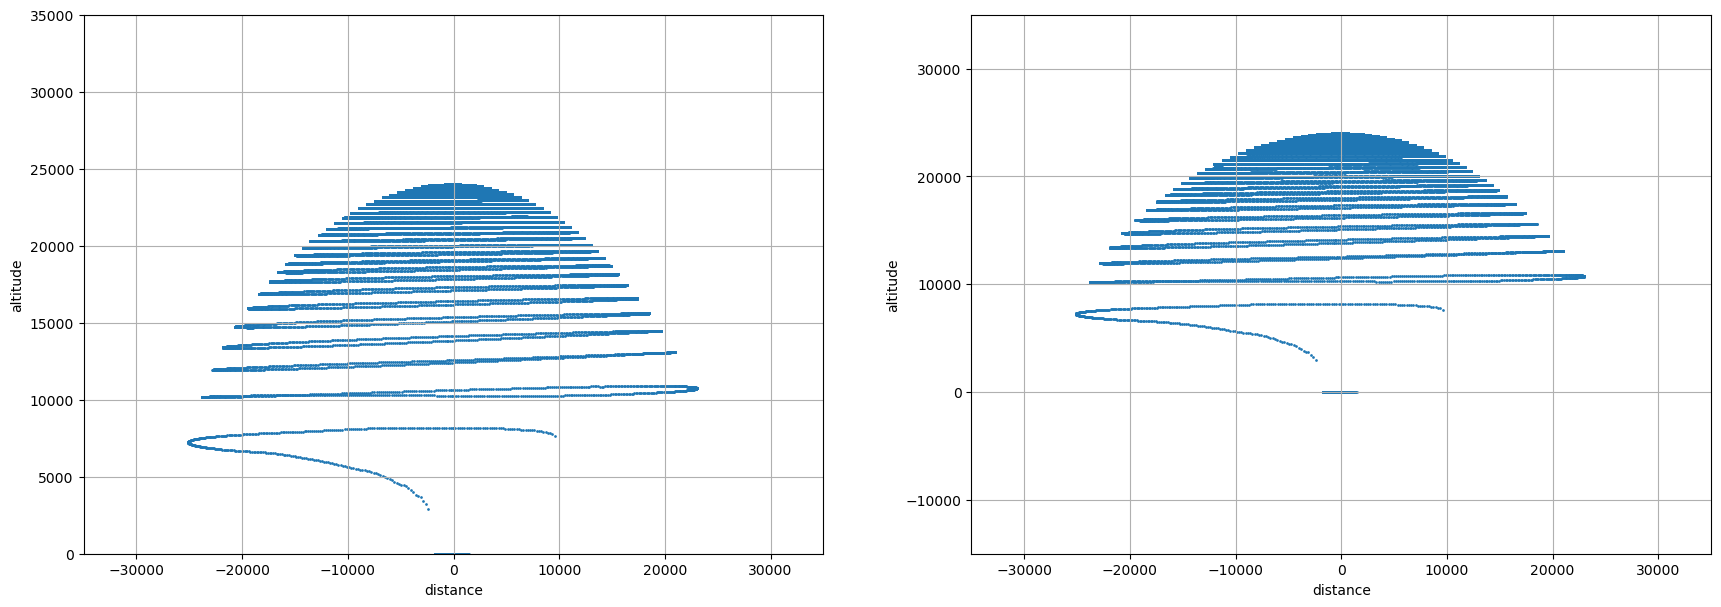

In [15]:
t_slice = 80

group_t = df.groupby('time')
df_t = group_t.get_group(t_slice)
df_t

plt.figure(figsize=(21, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-15 * 1000,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

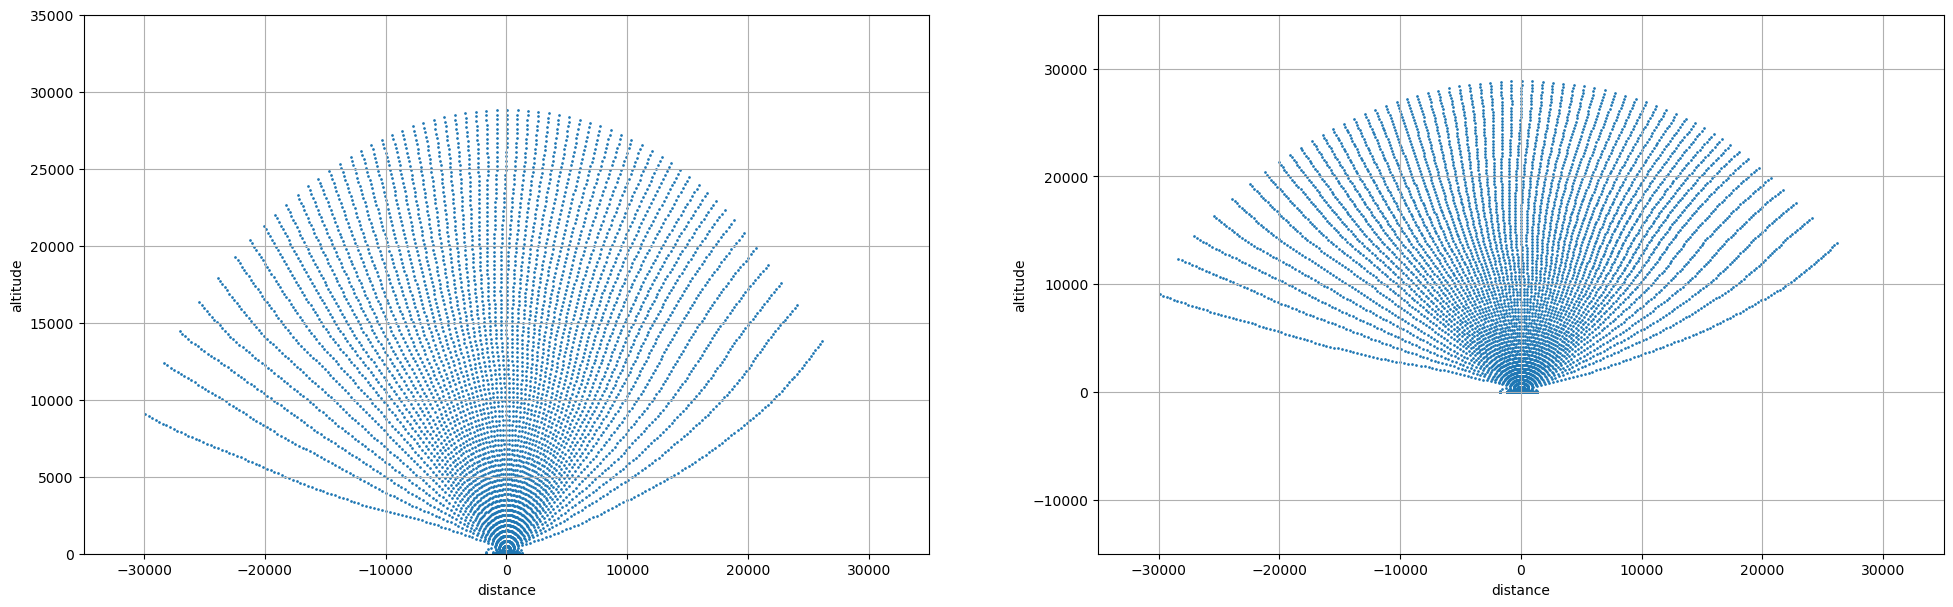

In [17]:
phi_slice= 1.570800

group_t = df.groupby('phi')
df_p = group_t.get_group(phi_slice)

plt.figure(figsize=(24, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_p['y'],df_p['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_p['y'],df_p['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-15 * 1000,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.show()


In [3]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_0.csv')
df

,x,y,z,theta,time,phi
0,0.0000,0.000000e+00,0.000000e+00,-1.57080,0,0.00000
1,-57.1666,4.510740e-33,3.500440e-15,-2.27332,1,0.00000
2,-57.1666,5.141960e-33,1.079420e-15,-2.88726,2,0.00000
3,-57.1666,5.199470e-33,2.893470e-16,-3.07692,3,0.00000
4,-57.1666,5.203630e-33,7.195370e-17,-3.12557,4,0.00000
...,...,...,...,...,...,...
61143945,-58.1269,1.117630e-04,4.277450e-56,3.14159,92,3.14159
61143946,-58.1269,1.117630e-04,1.057840e-56,3.14159,93,3.14159
61143947,-58.1269,1.117630e-04,2.616100e-57,3.14159,94,3.14159
61143948,-58.1269,1.117630e-04,6.469780e-58,3.14159,95,3.14159


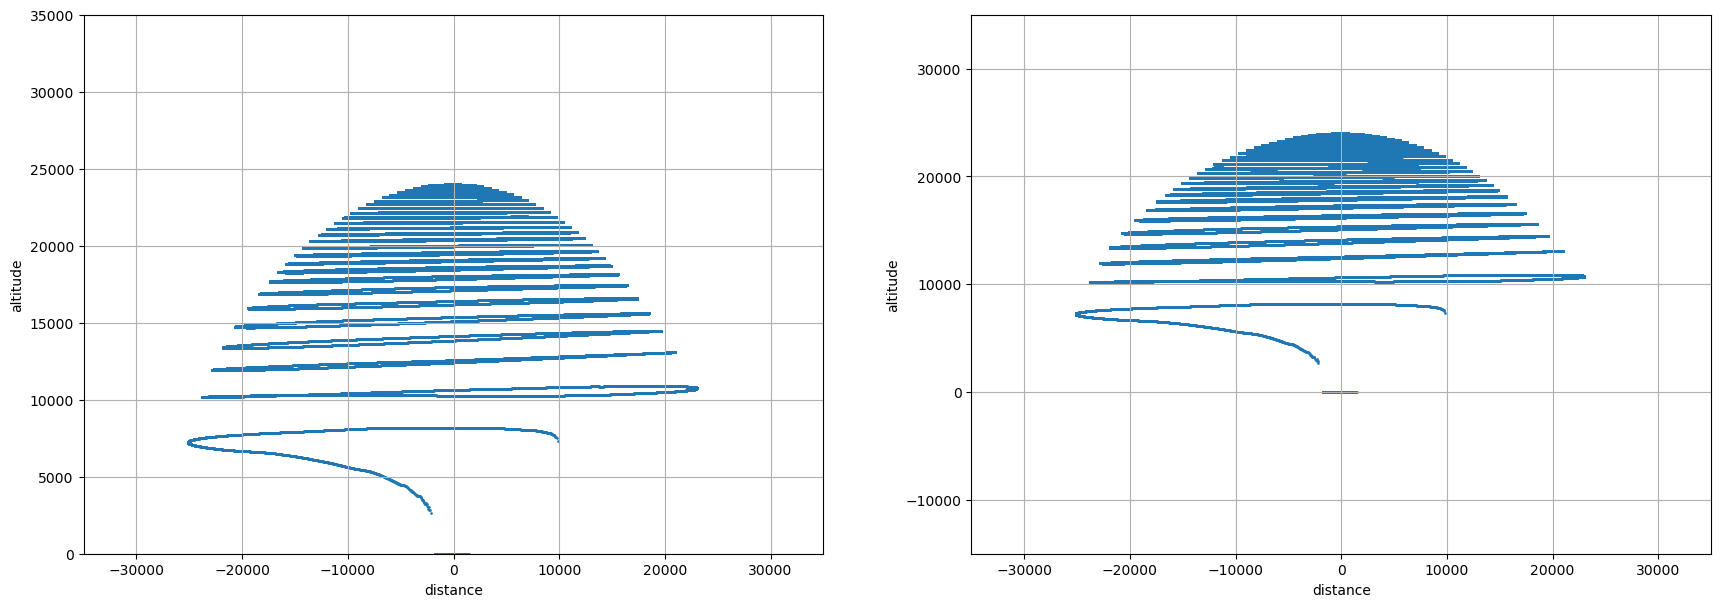

In [4]:
t_slice = 80

group_t = df.groupby('time')
df_t = group_t.get_group(t_slice)
df_t

plt.figure(figsize=(21, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-15 * 1000,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

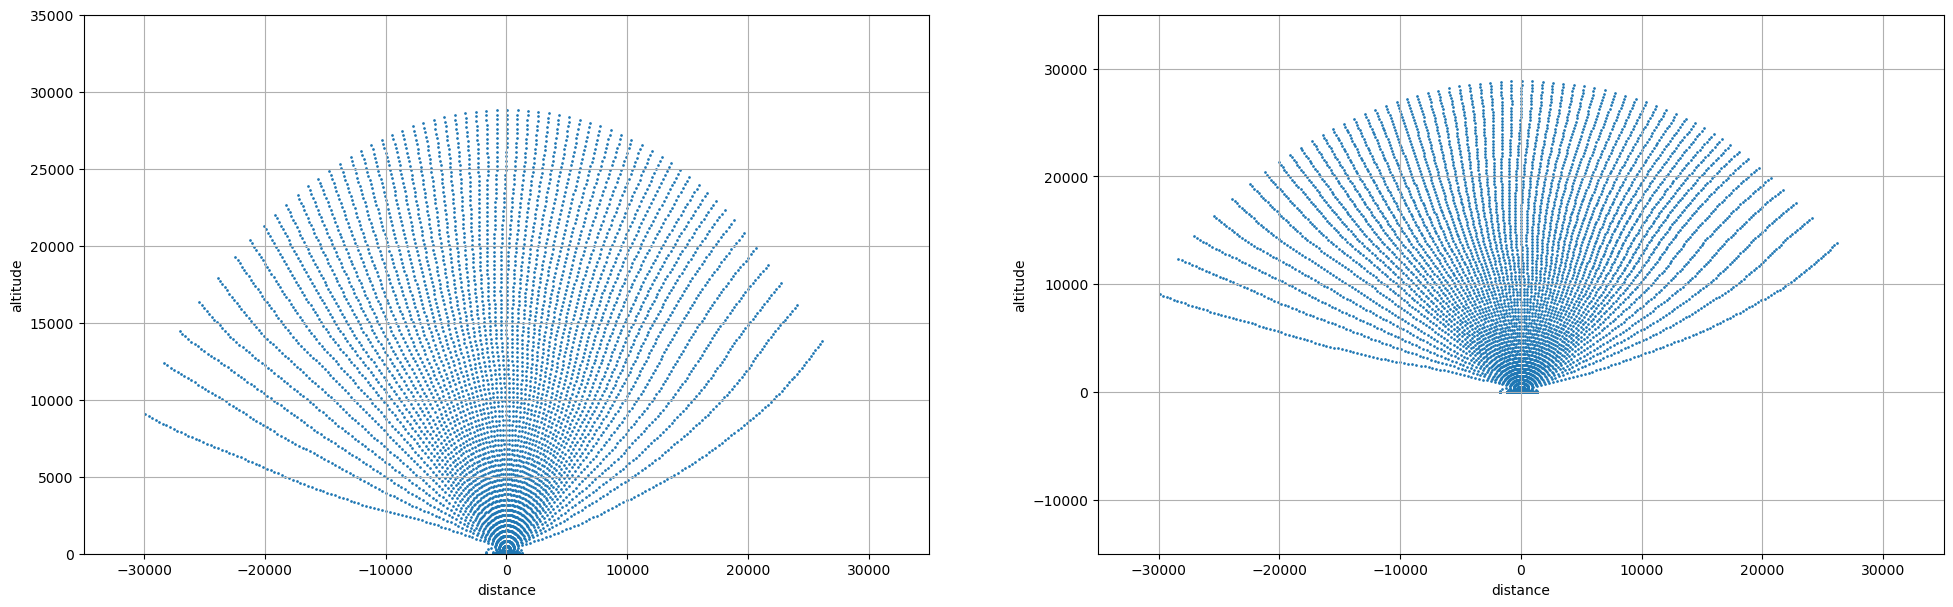

In [5]:
phi_slice= 1.570800

group_t = df.groupby('phi')
df_p = group_t.get_group(phi_slice)

plt.figure(figsize=(24, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_p['y'],df_p['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_p['y'],df_p['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-15 * 1000,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.show()


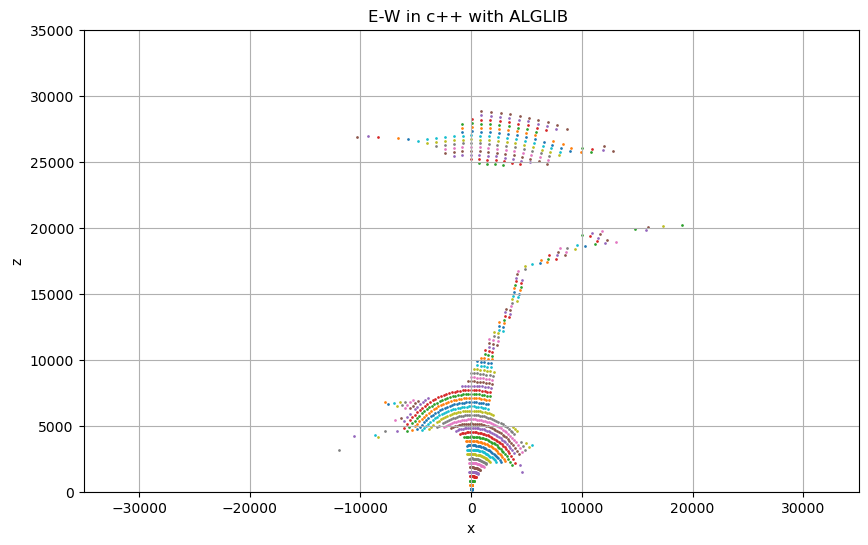

In [28]:
from scipy.interpolate import CubicSpline

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_0.csv')
dfa = dfa[dfa['phi'] != 0].reset_index(drop=True)
dfa = dfa[dfa['z']>0]
dfa = dfa[(dfa['theta'] <= np.pi/2) & (dfa['theta']>= -np.pi/2)]
dfa = dfa[(dfa['theta'] <= np.pi/2) & (dfa['phi']>= 0)]

group_t = dfa.groupby('time')

plt.figure(figsize=(10, 6))

for t in dfa['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).sort_values('y')
        df_ = df_.drop_duplicates(subset='y')
        
        wave_eq = CubicSpline(df_['y'],df_['z'])
        
        x_l = []
        y_l = []
        for x0 in df_['y'].to_numpy():
            
            dz_dx = wave_eq.derivative()(x0)
        
            land_x = x0 + wave_eq(x0) * dz_dx
            if np.abs(land_x) < 50:
                x_l.append(x0)
                y_l.append(wave_eq(x0))
        
        
        plt.scatter(x_l,y_l, s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.xlabel('x')
plt.ylabel('z')
plt.title('E-W in c++ with ALGLIB ')
plt.grid()
plt.show()

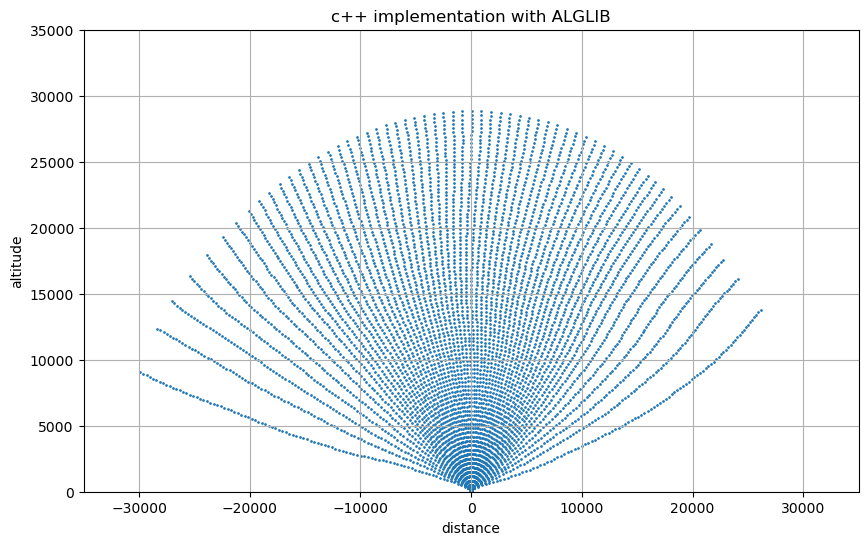

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(dfa['y'],dfa['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title("c++ implementation with ALGLIB")
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [21]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_0.csv')
df

,x,y,z,theta,time,phi
0,0.000000,0.000000e+00,0.000000e+00,-1.57080,0,0.0000
1,-57.166600,4.510740e-33,3.500440e-15,-2.27332,1,0.0000
2,-57.166600,5.141960e-33,1.079420e-15,-2.88726,2,0.0000
3,-57.166600,5.199470e-33,2.893470e-16,-3.07692,3,0.0000
4,-57.166600,5.203630e-33,7.195370e-17,-3.12557,4,0.0000
...,...,...,...,...,...,...
67895,0.000016,5.812700e+01,4.277320e-56,3.14159,92,1.5708
67896,0.000016,5.812700e+01,1.057810e-56,3.14159,93,1.5708
67897,0.000016,5.812700e+01,2.616030e-57,3.14159,94,1.5708
67898,0.000016,5.812700e+01,6.469590e-58,3.14159,95,1.5708


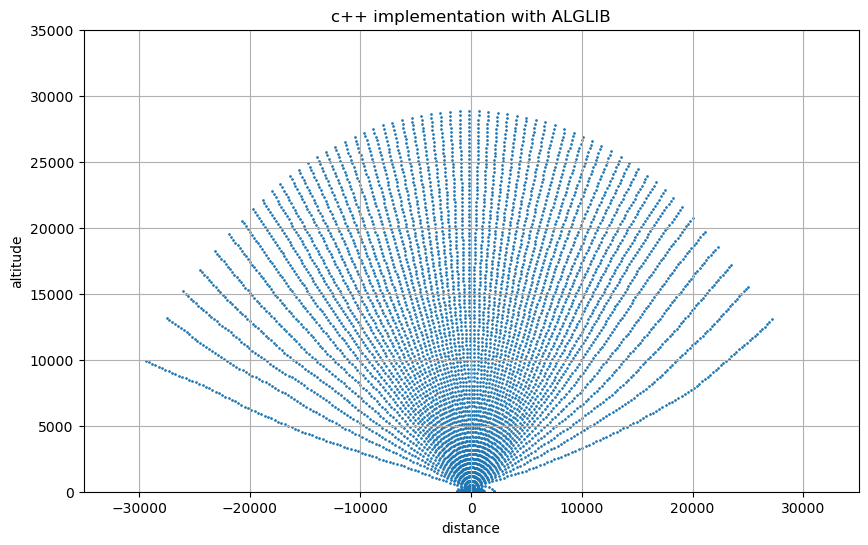

In [24]:
df = df[df['phi'] == 0]
plt.figure(figsize=(10, 6))
plt.scatter(df['x'],df['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title("c++ implementation with ALGLIB")
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import itertools
from scipy.interpolate import RegularGridInterpolator

# Load time steps
time_steps = np.loadtxt('/home/murali/Documents/rass/data/sim_data/dived_data/time_step.txt')

# Parameters
rounding_pic = 4
t_step = 84.0 

# Load data
df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/wTemp_wWind_0_{t_step}.csv')

# If t_step is not 0, process data
if t_step != 0:
    df_ = df.to_numpy()
    
    df_[:, 5] = np.round(df_[:, 5], decimals=rounding_pic)
    df_[:, 3] = np.round(df_[:, 3], decimals=rounding_pic)
    unique_phi = np.unique(df_[:, 5])
    unique_theta = np.unique(df_[:, 3])
    
    for phi in unique_phi:
        for theta in unique_theta:
            
            print('Phi values:', phi)
            print('Theta values:', theta)

            mask = 
            print(f"Mask: {mask}")

            points = df_[mask]
            
            if points.shape[0] < 1:
                print(f"--------------No points found for phi={phi} and theta={theta}-----------------")
                continue

            x = points[:, 0]
            y = points[:, 1]
            z = points[:, 2]

            print(f"x: {x}, y: {y}, z: {z}")

            # Using RegularGridInterpolator
            interpolator = RegularGridInterpolator((x, y), z)

            specific_point_row = df_[(df_[:, 5] == phi) & (df_[:, 3] == theta)]
            if specific_point_row.shape[0] == 0:
                print(f"No specific point found for phi={phi} and theta={theta}")
                continue
            
            specific_x, specific_y = specific_point_row[0, 0], specific_point_row[0, 1]
            specific_point = np.array([specific_x, specific_y])
            
            dz_dx = (interpolator([specific_point[0] + 1e-5, specific_point[1]]) - interpolator([specific_point[0] - 1e-5, specific_point[1]])) / 2e-5
            dz_dy = (interpolator([specific_point[0], specific_point[1] + 1e-5]) - interpolator([specific_point[0], specific_point[1] - 1e-5])) / 2e-5

            dz_dx = dz_dx.item()
            dz_dy = dz_dy.item()
            gradient = np.array([dz_dx, dz_dy, 1]) 

            point_3d = np.array([specific_point[0], specific_point[1], interpolator(specific_point).item()])

            t = -point_3d[2] / gradient[2]
            intersection = point_3d + t * gradient
            intersection_x, intersection_y = intersection[:2]
            print(f"Intersection at z=0: x={intersection_x}, y={intersection_y}")



In [12]:
t_step = 84.0
df = pd.read_csv(f'/home/murali/Documents/rass/data/sim_data/dived_data/py_data/wTemp_wWind_0_{t_step}.csv')
df

,x,y,z,theta,time,phi
0,1.056471e+06,-3.746361e+06,431.276298,-100.253168,84.0,0.000000
1,9.691274e+05,-3.434788e+06,946.886192,-106.542817,84.0,0.000000
2,2.148748e+06,-7.626692e+06,-10798.815748,-268.550142,84.0,0.000000
3,7.036461e+05,-2.495512e+06,3180.018571,-31.101961,84.0,0.000000
4,1.320573e+06,-4.699774e+06,-10097.509528,-130.463814,84.0,0.000000
...,...,...,...,...,...,...
630345,1.902092e+06,-6.741385e+06,-9694.604861,228.474738,84.0,3.141593
630346,4.926866e+05,-1.747915e+06,5476.041268,6.014104,84.0,3.141593
630347,1.027810e+06,-3.651929e+06,64.597598,112.802678,84.0,3.141593
630348,2.194030e+06,-7.778858e+06,-9174.994443,299.718245,84.0,3.141593


In [19]:
df['theta'].unique(), df['phi'].unique(),

(array([-100.25316789, -106.54281725, -268.55014243, ...,  112.80267801,
         299.71824453,  220.24089527]),
 array([0.00000000e+00, 1.74532925e-03, 3.49065850e-03, ...,
        3.13810200e+00, 3.13984732e+00, 3.14159265e+00]))

In [14]:
df_ = df.to_numpy()
df_

array([[ 1.05647128e+06, -3.74636061e+06,  4.31276298e+02,
        -1.00253168e+02,  8.40000000e+01,  0.00000000e+00],
       [ 9.69127400e+05, -3.43478846e+06,  9.46886192e+02,
        -1.06542817e+02,  8.40000000e+01,  0.00000000e+00],
       [ 2.14874816e+06, -7.62669153e+06, -1.07988157e+04,
        -2.68550142e+02,  8.40000000e+01,  0.00000000e+00],
       ...,
       [ 1.02780998e+06, -3.65192850e+06,  6.45975976e+01,
         1.12802678e+02,  8.40000000e+01,  3.14159265e+00],
       [ 2.19403043e+06, -7.77885801e+06, -9.17499444e+03,
         2.99718245e+02,  8.40000000e+01,  3.14159265e+00],
       [ 1.74973750e+06, -6.20078507e+06, -9.18483527e+03,
         2.20240895e+02,  8.40000000e+01,  3.14159265e+00]])

In [30]:
pts = df_[df_[:,3]==df_[:,3][0]]
pts[:,0]

array([1056471.28221472])

In [22]:
np.min(df_[:,0])

-27890.82112326873

In [2]:
bs_data = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/backscatter_coordinates.csv')
bs_data

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-340.183,-5.28795,31.7046,-121.752454,-3.339307,1,0.00000,-1.475670
1,-339.876,-5.19953,34.7764,-105.583244,-3.248708,1,0.00000,-1.466660
2,-339.542,-5.11155,37.8451,-88.731047,-3.179041,1,0.00000,-1.457660
3,-339.179,-5.02403,40.9104,-71.333619,-3.133845,1,0.00000,-1.448650
4,-338.790,-4.93696,43.9720,-53.805815,-3.116545,1,0.00000,-1.439640
...,...,...,...,...,...,...,...,...
8824487,161.698,-783.08400,28972.8000,37.873653,128.979885,96,1.95826,-0.031825
8824488,249.901,-994.00600,28964.6000,126.165263,-82.348657,96,1.96000,-0.039771
8824489,163.177,-782.47900,28972.8000,39.352926,129.585545,96,1.96000,-0.031825
8824490,251.747,-993.24600,28964.6000,128.011603,-81.587825,96,1.96175,-0.039771


In [9]:
bs_data.describe()

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
count,8.824492e+06,8.824492e+06,8.824492e+06,8.824492e+06,8.824492e+06,8.824492e+06,8.824492e+06,8.824492e+06
mean,-2.409593e+02,-5.550955e+02,2.758726e+03,2.605391e+01,1.948906e+01,1.050831e+01,1.533893e+00,-1.622646e-01
std,1.814321e+03,1.651852e+03,2.494545e+03,4.027321e+01,3.957684e+01,8.813913e+00,9.178225e-01,6.827877e-01
min,-1.471250e+04,-1.173280e+04,-8.276700e+03,-1.299999e+02,-1.299998e+02,1.000000e+00,0.000000e+00,-1.480110e+00
25%,-7.728040e+02,-1.110860e+03,1.052090e+03,4.904554e+00,1.912981e+00,4.000000e+00,7.260570e-01,-7.282830e-01
50%,-1.273375e+01,-1.395510e+02,2.298615e+03,2.833008e+01,2.484123e+01,9.000000e+00,1.511460e+00,-2.121540e-01
75%,5.658143e+02,2.984520e+02,3.827343e+03,4.550793e+01,3.792041e+01,1.400000e+01,2.330010e+00,3.554800e-01
max,1.557770e+04,8.954490e+03,2.897280e+04,1.299999e+02,1.299999e+02,9.600000e+01,3.141590e+00,2.993450e+00


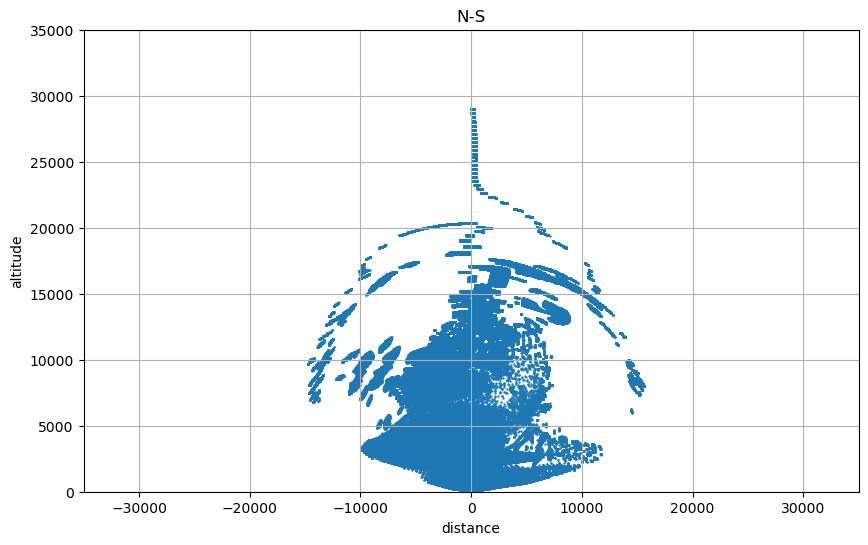

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['x_val'],bs_data['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('N-S')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

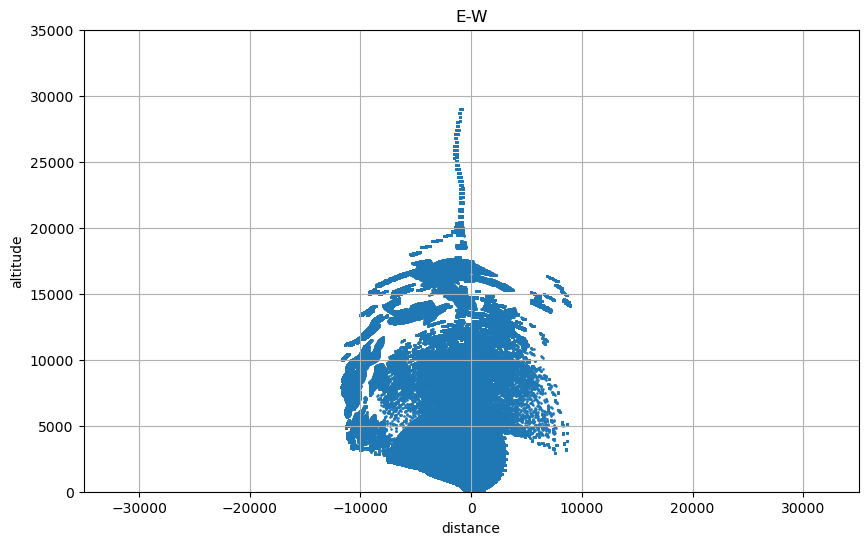

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['y_val'],bs_data['z_val'],s=0.8)
dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('E-W')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [11]:
bs = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/backscatter_coordinates_filt.csv')
bs

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-340.183,-5.28795,31.7046,-121.752455,-3.339307,1,0.00000,-1.475670
1,-339.876,-5.19953,34.7764,-105.583245,-3.248708,1,0.00000,-1.466660
2,-339.542,-5.11155,37.8451,-88.731049,-3.179041,1,0.00000,-1.457660
3,-339.179,-5.02403,40.9104,-71.333621,-3.133845,1,0.00000,-1.448650
4,-338.790,-4.93696,43.9720,-53.805817,-3.116545,1,0.00000,-1.439640
...,...,...,...,...,...,...,...,...
11502192,11055.200,23.84810,26706.1000,-116.635328,23.389077,96,2.97055,0.128254
11502193,-9894.550,32.59690,27310.2000,-126.381946,32.798171,96,2.97055,0.784347
11502194,-10088.000,32.10360,27240.0000,-121.303905,32.318051,96,2.97055,0.789777
11502195,-10287.000,31.55350,27166.7000,-119.016495,31.660476,96,2.97055,0.790655


In [12]:
bs.describe()

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
count,1.150220e+07,1.150220e+07,1.150220e+07,1.150220e+07,1.150220e+07,1.150220e+07,1.150220e+07,1.150220e+07
mean,-2.868412e+01,-1.757514e+02,4.403273e+03,1.958784e+01,1.308154e+01,1.564974e+01,1.482275e+00,3.142654e-02
std,2.117441e+03,1.927296e+03,4.866296e+03,4.906241e+01,4.997509e+01,1.654925e+01,8.763707e-01,9.082957e-01
min,-1.073100e+04,-9.781280e+03,3.832000e-03,-1.300000e+02,-1.299999e+02,1.000000e+00,0.000000e+00,-1.550930e+00
25%,-7.902840e+02,-8.868900e+02,1.356210e+03,1.437089e+00,-6.150517e+00,6.000000e+00,7.278020e-01,-7.311320e-01
50%,2.327840e+00,-3.690030e+01,3.070100e+03,2.609272e+01,2.191887e+01,1.200000e+01,1.438150e+00,-3.181600e-02
75%,6.891030e+02,5.735090e+02,5.658280e+03,4.610080e+01,3.859690e+01,2.000000e+01,2.242750e+00,6.950130e-01
max,1.654370e+04,2.003400e+04,2.731310e+04,1.300000e+02,1.299998e+02,9.600000e+01,3.132870e+00,3.140670e+00


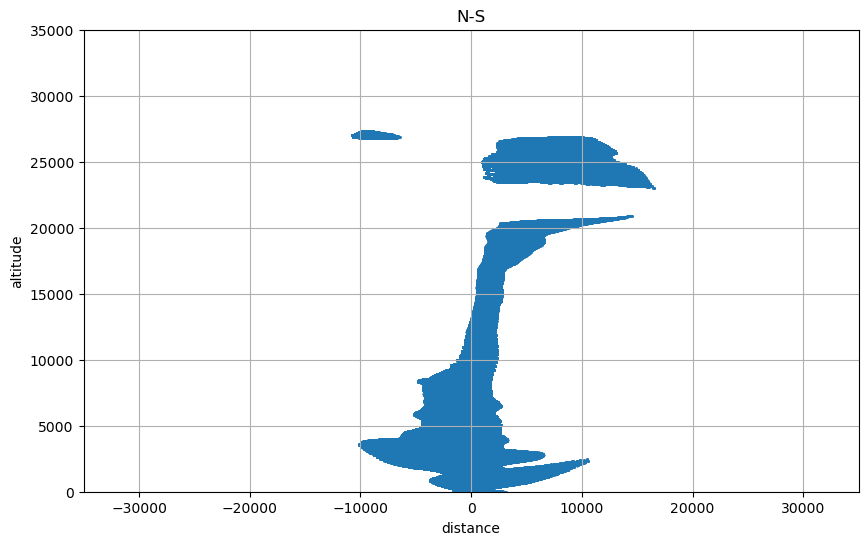

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(bs['x_val'],bs['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('N-S')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

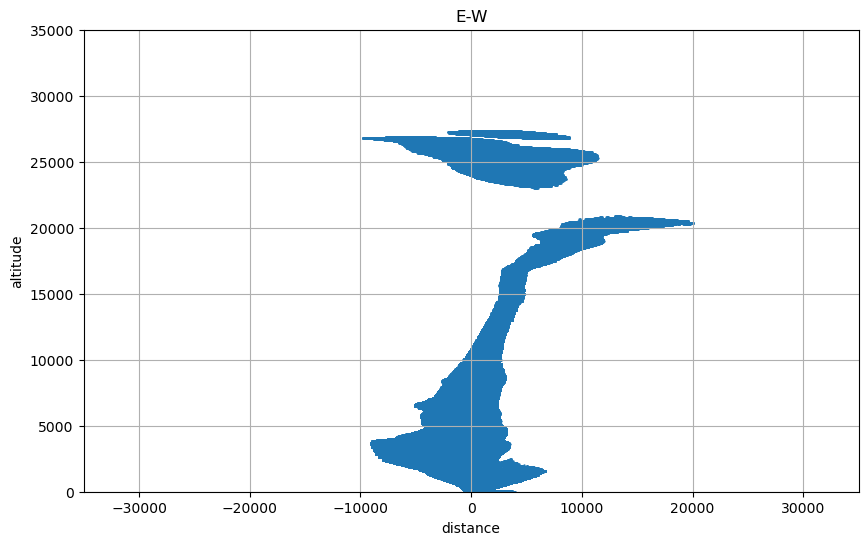

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(bs['y_val'],bs['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('E-W')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [8]:
bs_data = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/backscatter_coordinates_filt.csv')
bs_data

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-343.104,128.8370,8.95995,113.693659,117.952554,1,0.00000,-1.987580
1,-343.601,128.2810,12.07540,84.305370,117.689899,1,0.00000,-1.977210
2,-344.063,127.7300,15.20370,57.071463,117.124665,1,0.00000,-1.966780
3,-344.488,127.1830,18.34440,32.221577,116.376723,1,0.00000,-1.956280
4,-344.877,126.6410,21.49690,9.758950,115.546540,1,0.00000,-1.945720
...,...,...,...,...,...,...,...,...
5353419,16946.600,-136.4760,23421.80000,-3.234808,-44.924362,96,2.73842,-0.151474
5353420,16781.300,-124.4270,23536.90000,-89.269614,-55.525344,96,2.73842,-0.142766
5353421,17126.500,-119.4520,23294.10000,95.878139,-23.699548,96,2.74017,-0.811059
5353422,16942.200,-106.1290,23424.90000,-2.922813,-36.314603,96,2.74017,-0.803389


In [9]:
bs_data.describe()

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
count,5.353424e+06,5.353424e+06,5.353424e+06,5.353424e+06,5.353424e+06,5.353424e+06,5.353424e+06,5.353424e+06
mean,3.478758e+01,-2.783100e+02,4.641688e+03,-1.900073e+01,8.857703e+01,1.533993e+01,1.331939e+00,-7.313761e+00
std,1.799768e+03,1.727314e+03,3.947034e+03,4.605351e+01,5.338058e+01,1.365011e+01,7.753257e-01,3.762297e+01
min,-1.897030e+04,-1.482390e+04,3.306000e-03,-1.300000e+02,-1.299997e+02,1.000000e+00,0.000000e+00,-2.632590e+03
25%,-4.036940e+02,-5.444462e+02,1.344660e+03,-4.529988e+01,8.164829e+01,5.000000e+00,6.440260e-01,-1.078970e+00
50%,-1.840250e+01,3.329345e+01,4.086150e+03,-2.285641e+01,1.102161e+02,1.400000e+01,1.370080e+00,-1.904750e-02
75%,4.607950e+02,2.747340e+02,6.733900e+03,-2.331744e+00,1.216396e+02,2.200000e+01,2.021090e+00,7.202850e-01
max,1.865170e+04,1.638030e+04,2.864180e+04,1.299999e+02,1.300000e+02,9.600000e+01,2.888520e+00,1.727930e+02


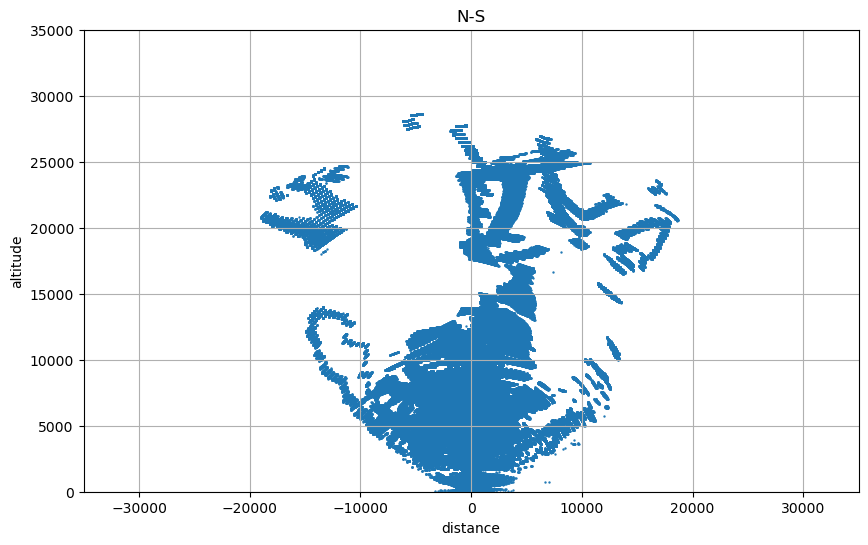

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['x_val'],bs_data['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('N-S')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

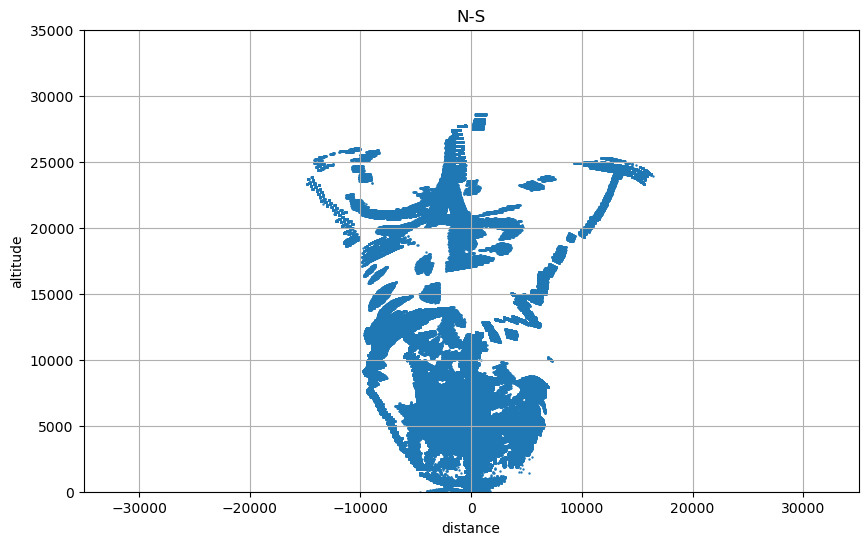

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['y_val'],bs_data['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('N-S')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

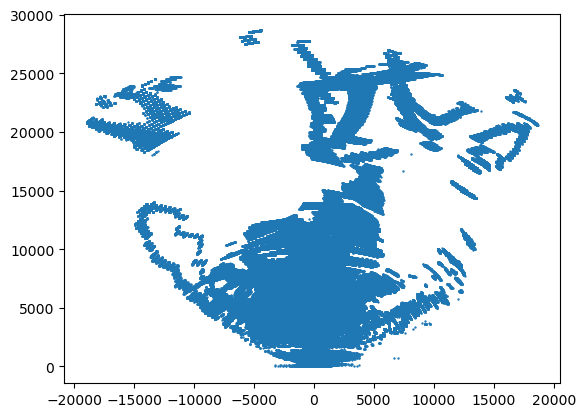

In [12]:
plt.scatter(bs_data['x_val'],bs_data['z_val'], s=0.5)

In [13]:
bs_data = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/backscatter_coordinates_unfilt.csv')
bs_data

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-297.001,103.5210,206.301,-17.187181,100.029861,1,0.00000,-0.951830
1,-295.033,103.2800,209.031,-92.927343,75.215444,1,0.00000,-0.939653
2,-288.935,102.5830,217.071,-124.091346,68.787022,1,0.00000,-0.903289
3,-286.839,102.3590,219.700,-97.869563,76.336560,1,0.00000,-0.891225
4,-284.712,102.1400,222.303,-72.639917,84.751819,1,0.00000,-0.879190
...,...,...,...,...,...,...,...,...
2362462,4261.350,22.5868,28619.600,-117.602709,102.953765,96,3.11367,-0.158128
2362463,4261.280,30.4541,28619.600,-116.645136,109.563271,96,3.11541,-0.158119
2362464,4261.200,38.3207,28619.700,-115.690446,116.171035,96,3.11716,-0.158110
2362465,4261.110,46.1867,28619.700,-114.738627,122.777139,96,3.11890,-0.158102


In [14]:
bs_data.describe()

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
count,2.362467e+06,2.362467e+06,2.362467e+06,2.362467e+06,2.362467e+06,2.362467e+06,2.362467e+06,2.362467e+06
mean,-1.564455e+00,3.087267e+02,3.660838e+03,-2.018903e+01,4.154452e+01,1.271479e+01,1.572841e+00,2.485613e-02
std,1.623926e+03,1.762019e+03,3.503237e+03,6.071167e+01,7.433206e+01,1.172806e+01,8.824485e-01,6.584401e-01
min,-8.639920e+03,-7.497670e+03,-2.240200e+03,-1.299999e+02,-1.299999e+02,1.000000e+00,0.000000e+00,-1.780630e+01
25%,-3.158215e+02,-2.063480e+02,6.379610e+02,-5.321060e+01,-1.621860e+01,2.000000e+00,8.272860e-01,-3.740790e-01
50%,-4.916410e+00,1.513570e+02,3.292090e+03,-4.082005e+01,6.965082e+01,1.100000e+01,1.583010e+00,7.457000e-02
75%,5.082905e+02,7.103740e+02,5.177040e+03,1.879456e+01,1.037072e+02,1.700000e+01,2.310820e+00,4.958250e-01
max,1.042600e+04,6.324330e+03,2.861980e+04,1.299998e+02,1.299998e+02,9.600000e+01,3.141590e+00,1.156110e+01


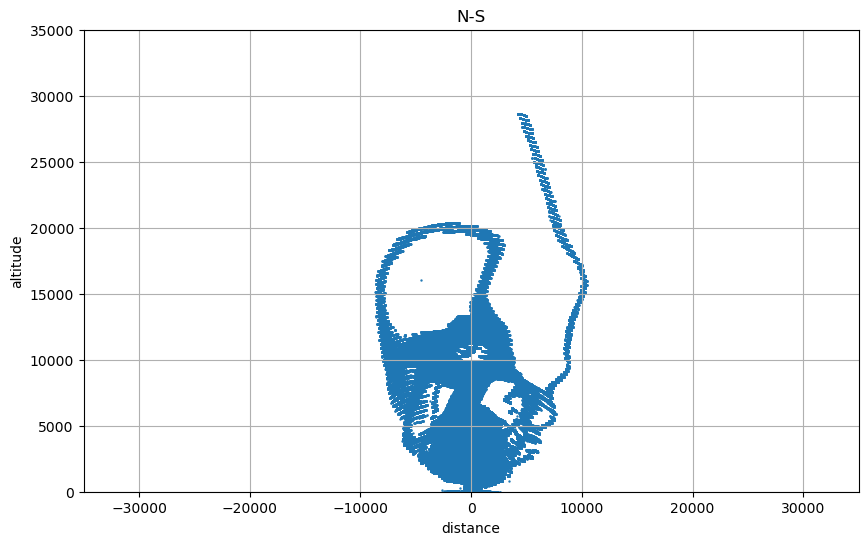

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['x_val'],bs_data['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('N-S')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

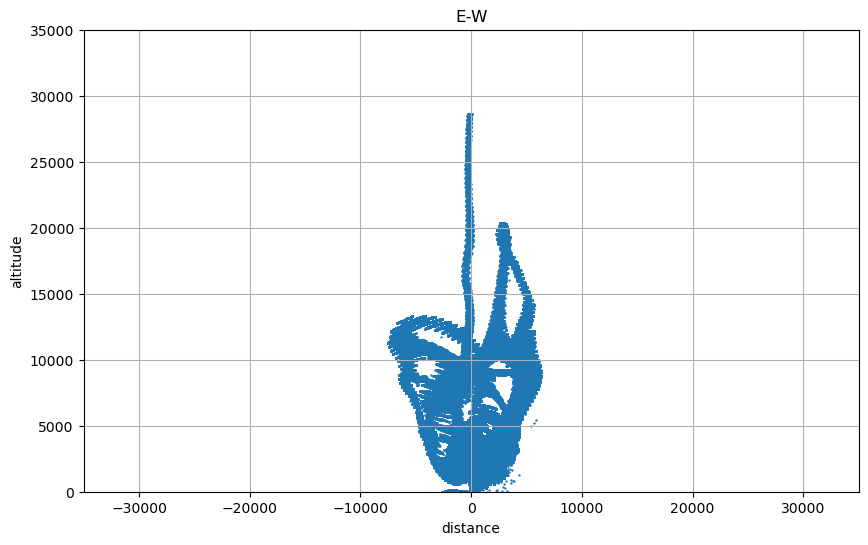

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['y_val'],bs_data['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('E-W')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [17]:
bs_data = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/backscatter_coordinates_filt1.csv')
bs_data

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-343.104,128.8370,8.95995,113.693659,117.952554,1,0.00000,-1.987580
1,-343.601,128.2810,12.07540,84.305370,117.689899,1,0.00000,-1.977210
2,-344.063,127.7300,15.20370,57.071463,117.124665,1,0.00000,-1.966780
3,-344.488,127.1830,18.34440,32.221577,116.376723,1,0.00000,-1.956280
4,-344.877,126.6410,21.49690,9.758950,115.546540,1,0.00000,-1.945720
...,...,...,...,...,...,...,...,...
6106734,12155.800,98.1394,26182.70000,-115.767842,95.998917,96,2.40506,-0.508278
6106735,11955.600,101.8700,26275.50000,-129.811371,96.046368,96,2.40506,-0.501941
6106736,11564.100,109.9900,26451.50000,-129.473236,98.222442,96,2.40506,-0.481150
6106737,11357.500,114.1030,26541.90000,-117.308150,104.543790,96,2.40506,-0.476998


In [18]:
bs_data.describe()

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
count,6.106739e+06,6.106739e+06,6.106739e+06,6.106739e+06,6.106739e+06,6.106739e+06,6.106739e+06,6.106739e+06
mean,5.622937e+02,-1.276414e+02,5.964626e+03,-2.038721e+01,7.212885e+01,2.002728e+01,1.229934e+00,-1.059111e+01
std,2.370177e+03,2.159593e+03,5.705801e+03,4.917515e+01,6.677229e+01,2.027770e+01,7.494074e-01,5.421172e+01
min,-1.758500e+04,-3.006590e+04,3.306000e-03,-1.300000e+02,-1.300000e+02,1.000000e+00,0.000000e+00,-2.627860e+03
25%,-3.139020e+02,-6.735205e+02,1.681360e+03,-4.741712e+01,4.314883e+01,6.000000e+00,5.811950e-01,-1.068950e+00
50%,4.277670e+01,3.990760e+01,4.671320e+03,-2.322692e+01,1.037867e+02,1.600000e+01,1.185080e+00,-9.388000e-03
75%,8.190980e+02,3.318500e+02,7.721220e+03,-1.594617e+00,1.201752e+02,2.500000e+01,1.902410e+00,7.087450e-01
max,1.869010e+04,2.027820e+04,2.823960e+04,1.299994e+02,1.300000e+02,9.600000e+01,2.888520e+00,1.747960e+02


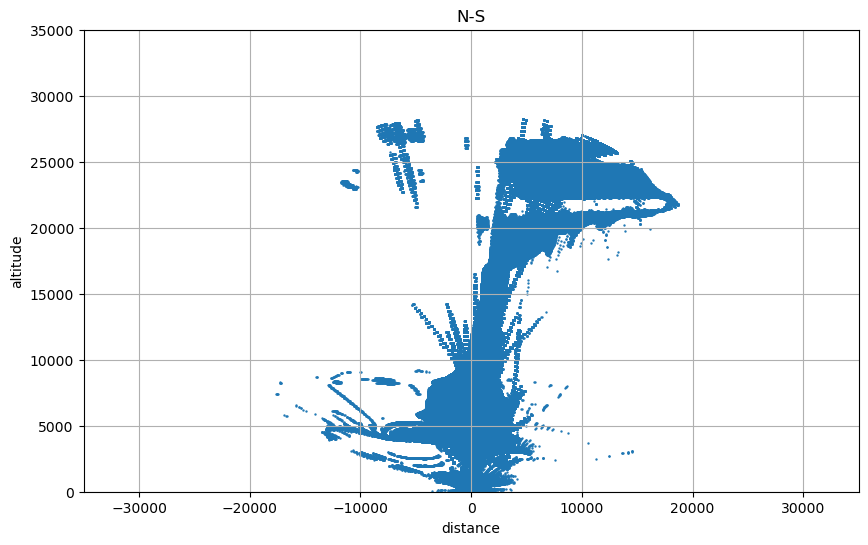

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['x_val'],bs_data['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('N-S')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

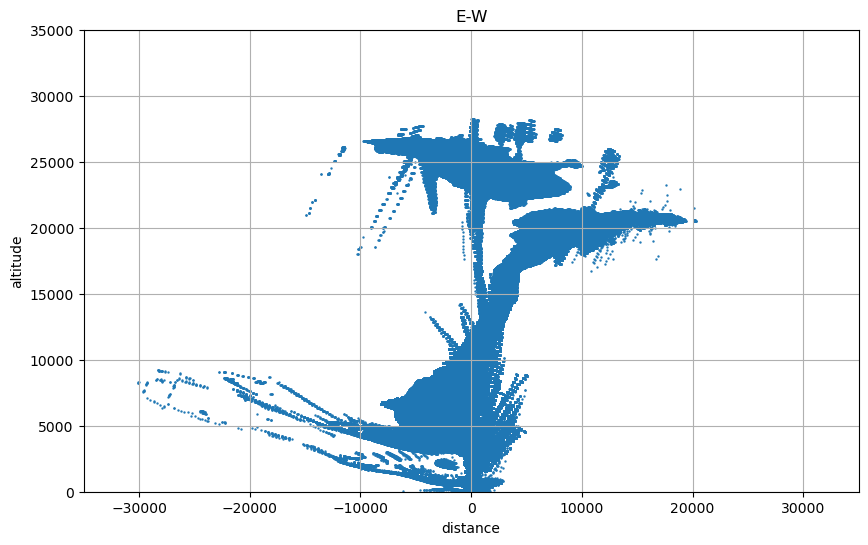

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(bs_data['y_val'],bs_data['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('E-W')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

In [2]:
df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/cpp_sim/ideal_cnds_0.csv')
df

,x,y,z,theta,time,phi
0,0.0,0.000000e+00,0.000000e+00,-1.57080,0,0.00000
1,-343.0,0.000000e+00,2.100270e-14,-1.57080,1,0.00000
2,-686.0,0.000000e+00,4.200540e-14,-1.57080,2,0.00000
3,-1029.0,0.000000e+00,6.300810e-14,-1.57080,3,0.00000
4,-1372.0,0.000000e+00,8.401080e-14,-1.57080,4,0.00000
...,...,...,...,...,...,...
55470795,-28467.9,3.758240e-09,2.555340e+02,1.56182,83,3.14159
55470796,-28810.8,3.803520e-09,2.586120e+02,1.56182,84,3.14159
55470797,-29153.8,3.848800e-09,2.616910e+02,1.56182,85,3.14159
55470798,-29496.8,3.894080e-09,2.647700e+02,1.56182,86,3.14159


In [3]:
phi_unique = df['phi'].unique()
len(phi_unique)

1801

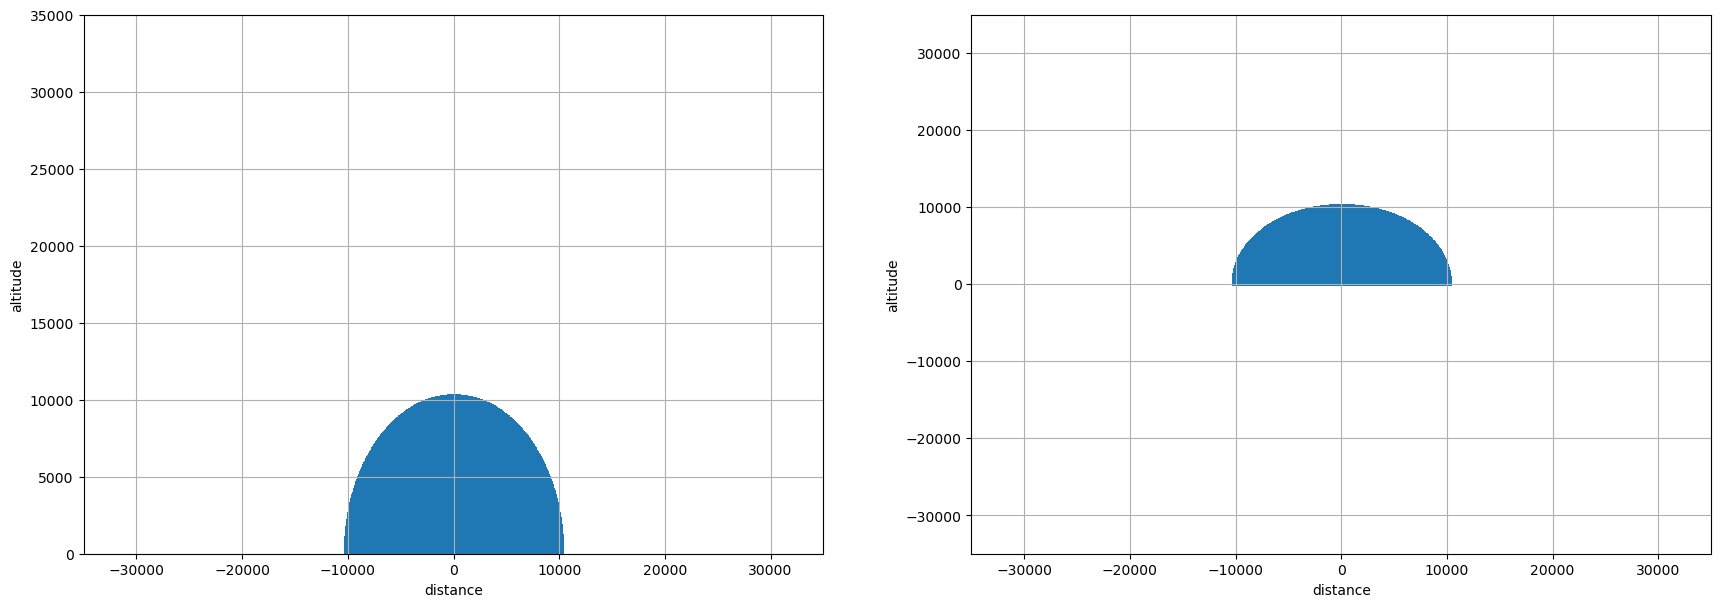

In [6]:
time_slice = 30
group_t = df.groupby('time')
df_t = group_t.get_group(time_slice)

plt.figure(figsize=(21, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_t['y'],df_t['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

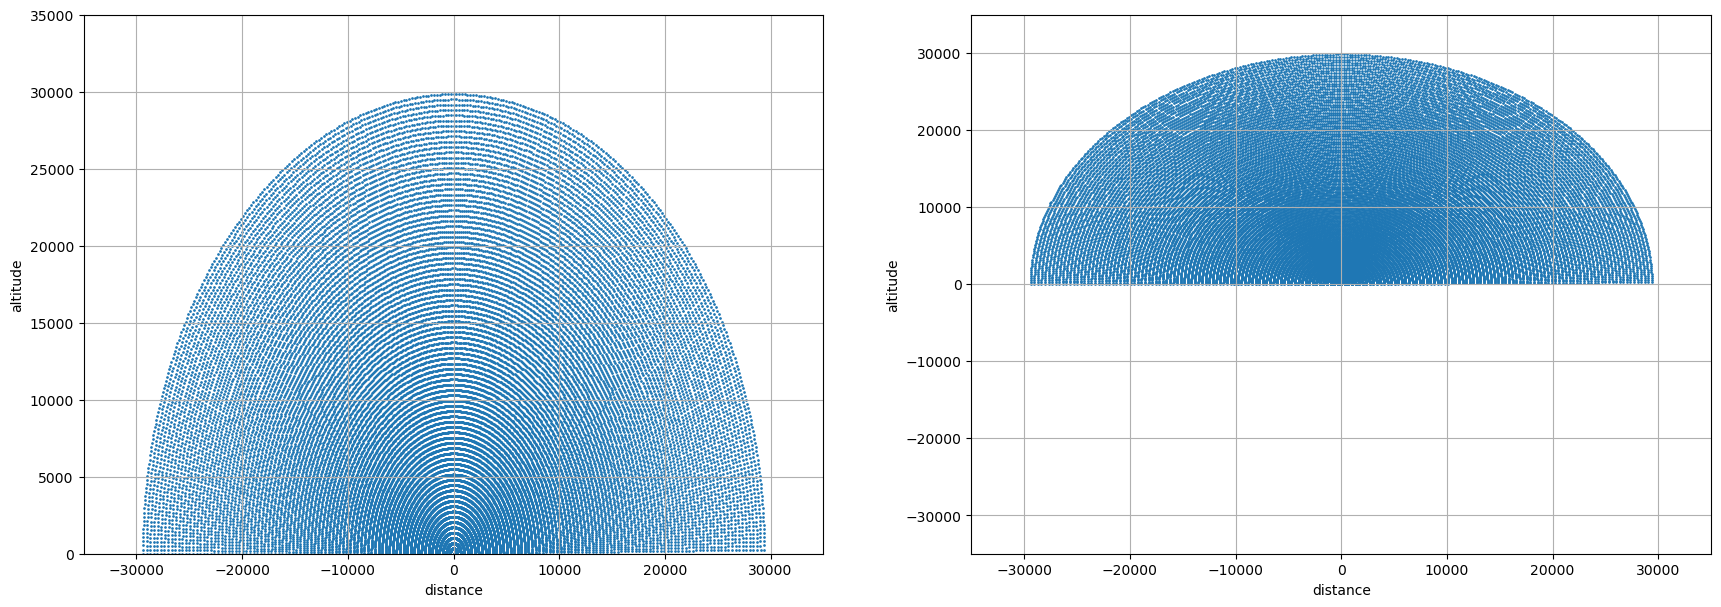

In [5]:
phi_slice = phi_unique[800]
group_p = df.groupby('phi')
df_p = group_p.get_group(phi_slice)
plt.figure(figsize=(21, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_p['y'],df_p['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_p['y'],df_p['z'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

In [2]:
df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/dived_data/cpp_data/alglib_CS_i_0/backscatter_coordinates_i_0.csv')
df

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-341.619,0.0,30.7463,-125.688598,2.157033,1,0.00000,-1.48104
1,-341.329,0.0,33.8114,-109.487855,2.199884,1,0.00000,-1.47206
2,-341.012,0.0,36.8737,-92.462750,2.223813,1,0.00000,-1.46308
3,-340.668,0.0,39.9331,-74.838771,2.224084,1,0.00000,-1.45411
4,-340.295,0.0,42.9893,-56.783349,2.196053,1,0.00000,-1.44513
...,...,...,...,...,...,...,...,...
41835066,-26768.500,0.0,13188.3000,112.313778,2.707697,87,3.14159,1.11302
41835067,-26885.800,0.0,12947.5000,80.610723,3.679072,87,3.14159,1.12200
41835068,-27000.900,0.0,12705.7000,16.962066,4.666281,87,3.14159,1.13097
41835069,-27113.900,0.0,12462.8000,-79.765846,5.516221,87,3.14159,1.13995


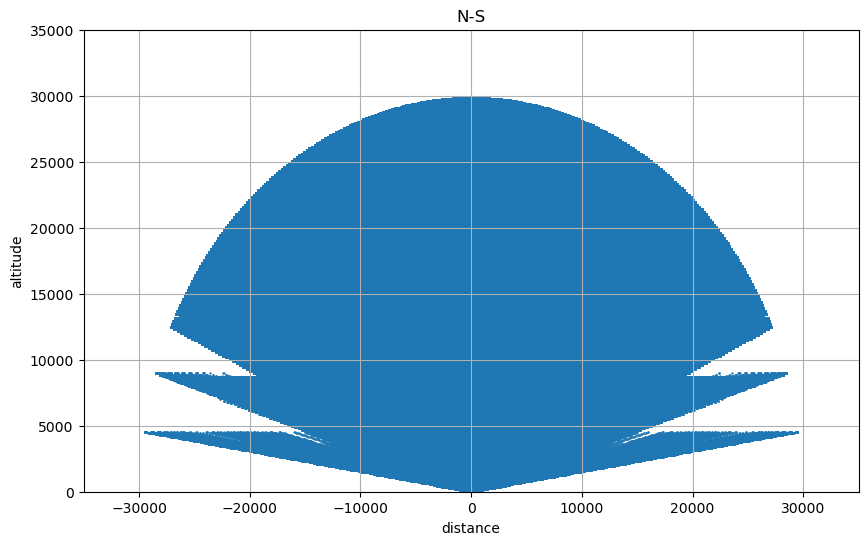

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(df['x_val'],df['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('N-S')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

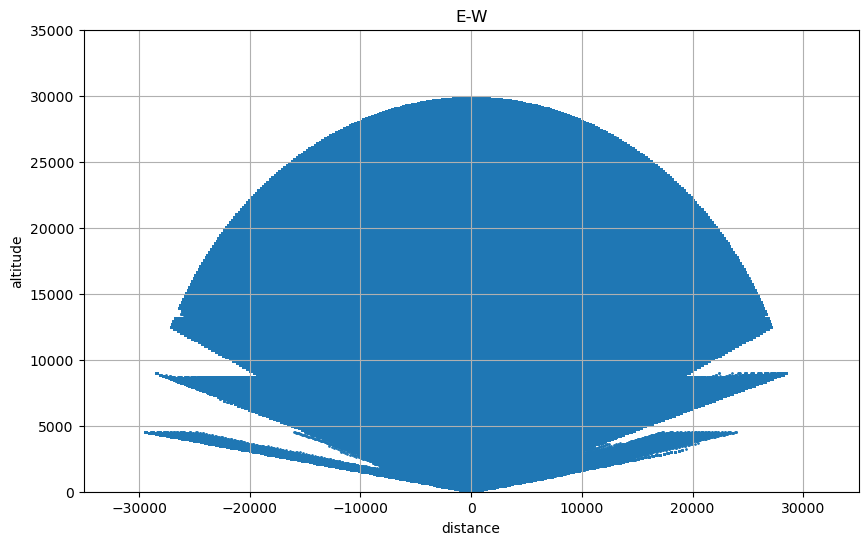

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_val'],df['z_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
plt.title('E-W')
plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

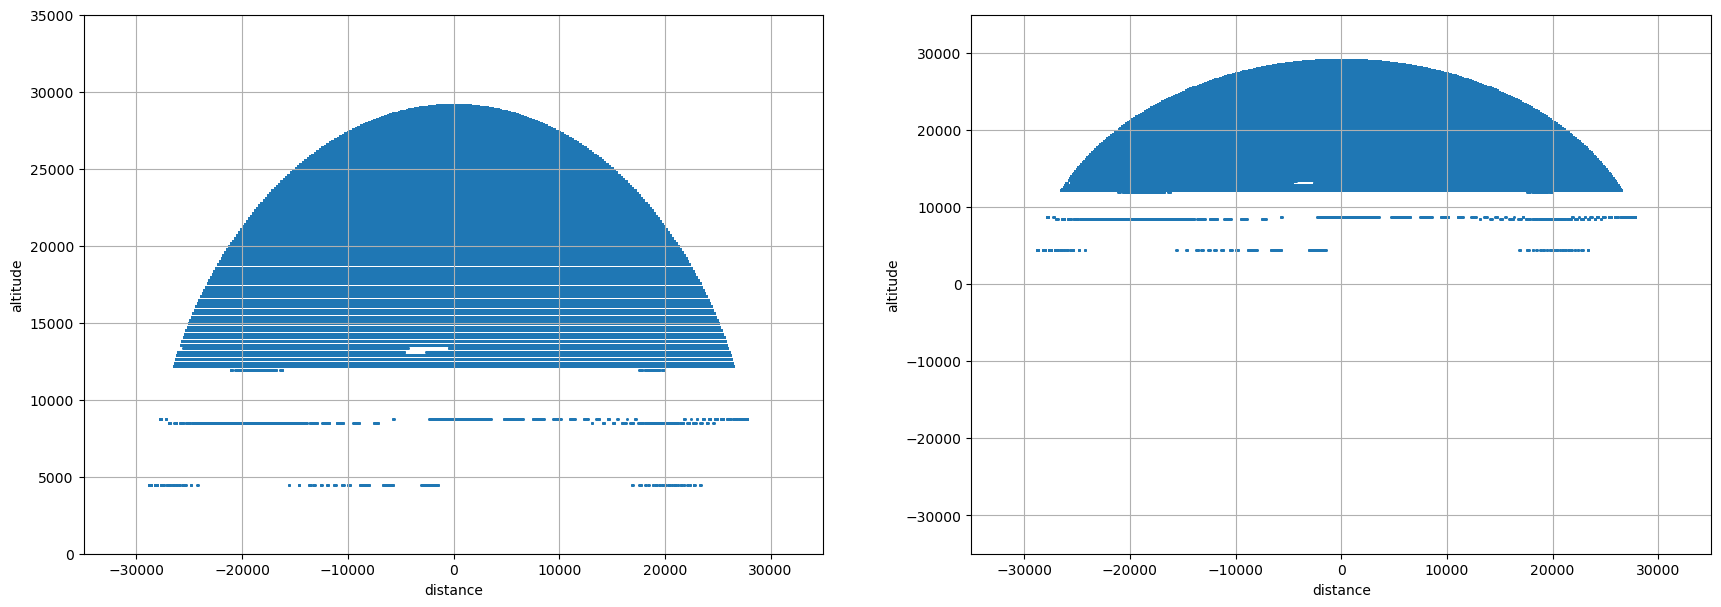

In [6]:
time_slice = 85
group_t = df.groupby('time_step')
df_t = group_t.get_group(time_slice)

plt.figure(figsize=(21, 7))

plt.subplot(1, 2, 1)
plt.scatter(df_t['y_val'],df_t['z_val'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((0,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_t['y_val'],df_t['z_val'], s=0.9)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
# plt.title("Ideal Conditions")
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/dived_data/cpp_data/alglib_CS_i_0/backscatter_coordinates_i_0.csv')
df

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-342.503,0.0,18.4636,-106.505497,4.167087,1,0.00000,-1.51694
1,-342.323,0.0,21.5371,-73.939359,4.186797,1,0.00000,-1.50796
2,-342.116,0.0,24.6089,-40.697899,4.018961,1,0.00000,-1.49899
3,-341.881,0.0,27.6787,-9.250857,3.631246,1,0.00000,-1.49001
4,-341.619,0.0,30.7463,16.855172,3.036625,1,0.00000,-1.48104
...,...,...,...,...,...,...,...,...
47608297,-28693.200,0.0,8196.6800,43.533783,0.262460,87,3.14159,1.29254
47608298,-28765.600,0.0,7938.8100,61.954893,1.177001,87,3.14159,1.30152
47608299,-28835.700,0.0,7680.2900,63.126723,2.531782,87,3.14159,1.31049
47608300,-28903.500,0.0,7421.1500,33.185585,4.148405,87,3.14159,1.31947


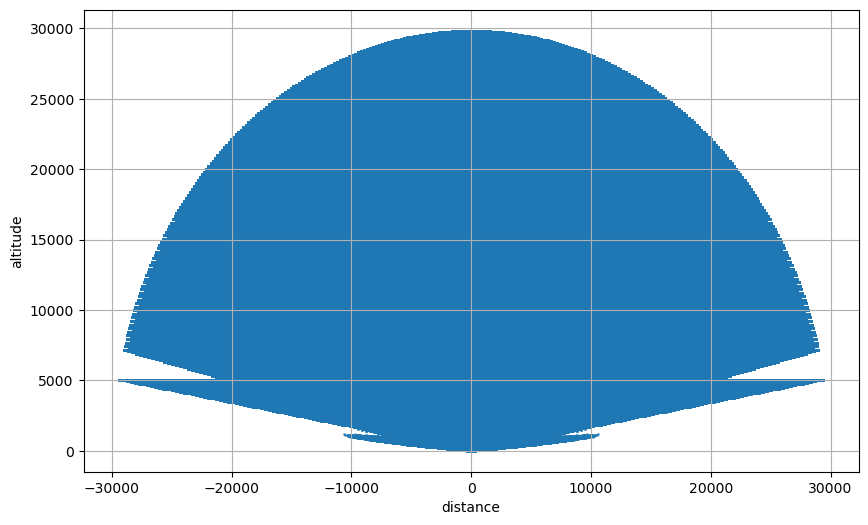

In [2]:
plt.subplot(1, 3, 1)
plt.figure(figsize=(10, 6))
plt.scatter(df['x_val'],df['z_val'], s=0.5)

plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

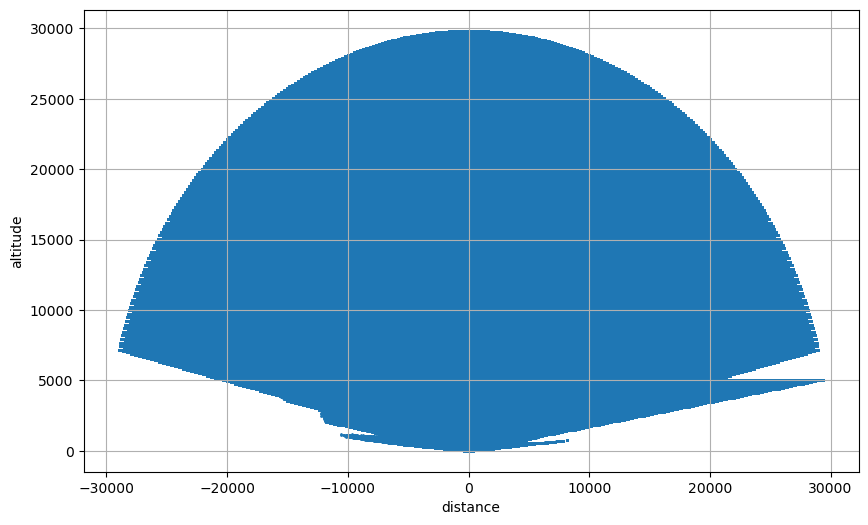

In [9]:
plt.subplot(1, 3, 2)
plt.figure(figsize=(10, 6))
plt.scatter(df['y_val'],df['z_val'], s=0.5)


plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

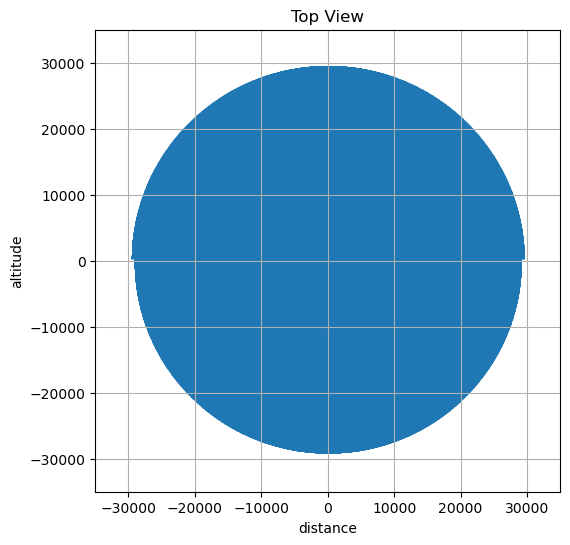

In [12]:
plt.subplot(1, 3, 3)
plt.figure(figsize=(6, 6))
plt.scatter(df['x_val'],df['y_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
plt.title('Top View')
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/home/murali/Documents/rass/data/sim_data/dived_data/cpp_data/alglib_CS_i_0/backscatter_coordinates_i_0_G500-r2.csv')
df

,x_val,y_val,z_val,x_land,y_land,time_step,phi,theta
0,-342.503,0.0,18.4636,-106.505497,4.167087,1,0.00000,-1.51694
1,-342.323,0.0,21.5371,-73.939359,4.186797,1,0.00000,-1.50796
2,-342.116,0.0,24.6089,-40.697899,4.018961,1,0.00000,-1.49899
3,-341.881,0.0,27.6787,-9.250857,3.631246,1,0.00000,-1.49001
4,-341.619,0.0,30.7463,16.855172,3.036625,1,0.00000,-1.48104
...,...,...,...,...,...,...,...,...
47608297,-28693.200,0.0,8196.6800,43.533783,0.262460,87,3.14159,1.29254
47608298,-28765.600,0.0,7938.8100,61.954893,1.177001,87,3.14159,1.30152
47608299,-28835.700,0.0,7680.2900,63.126723,2.531782,87,3.14159,1.31049
47608300,-28903.500,0.0,7421.1500,33.185585,4.148405,87,3.14159,1.31947


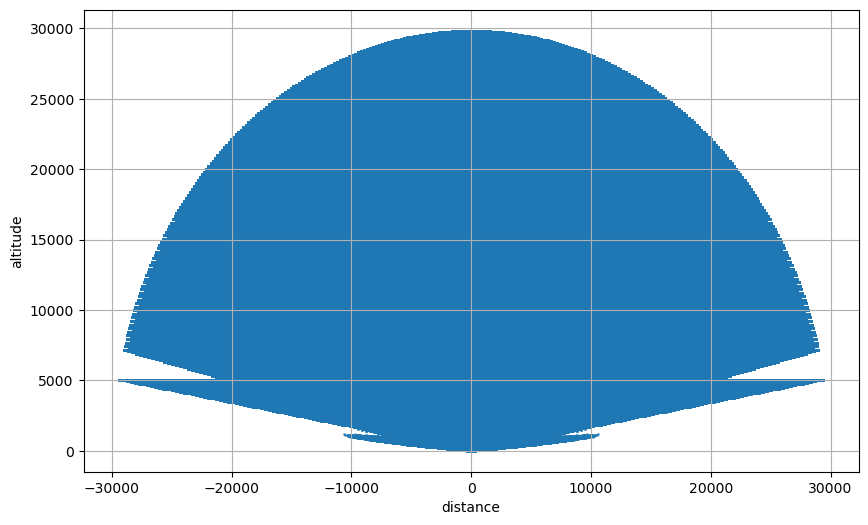

In [2]:
plt.figure(figsize=(10, 6))
plt.scatter(df['x_val'],df['z_val'], s=0.5)

plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

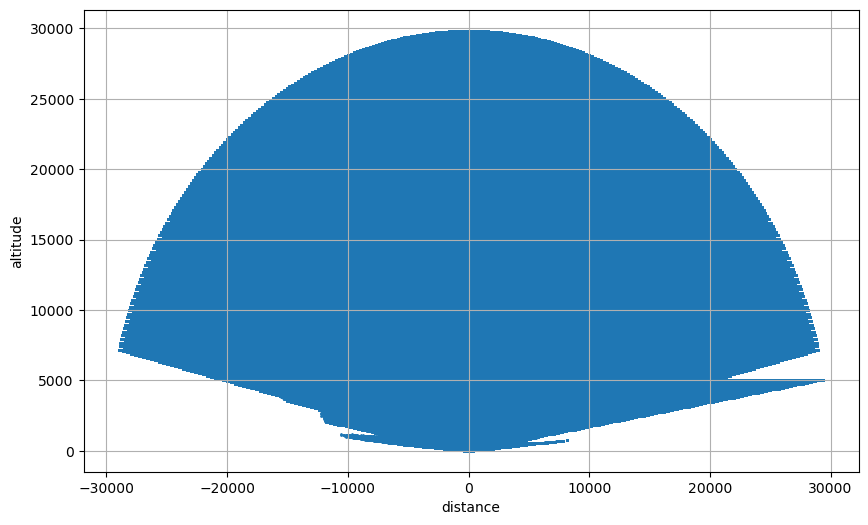

In [3]:

plt.figure(figsize=(10, 6))
plt.scatter(df['y_val'],df['z_val'], s=0.5)


plt.xlabel("distance")
plt.ylabel("altitude")

plt.grid()
plt.show()

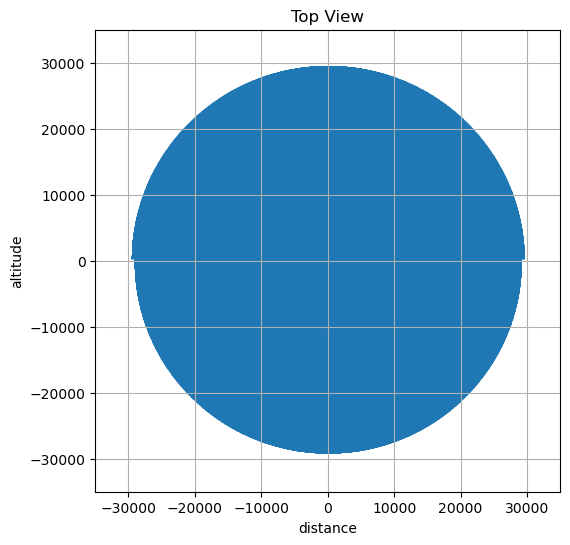

In [4]:
plt.figure(figsize=(6, 6))
plt.scatter(df['x_val'],df['y_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
plt.title('Top View')
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()

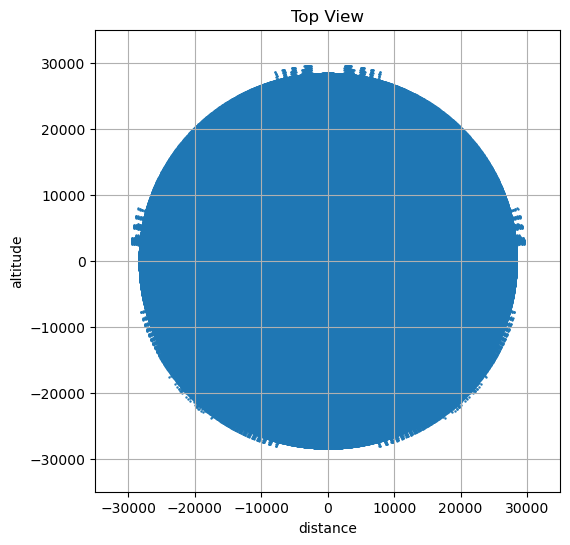

In [4]:
plt.figure(figsize=(6, 6))
plt.scatter(df['x_val'],df['y_val'], s=0.5)

dist = 35 * 1000
plt.xlim((-dist,dist))
plt.ylim((-dist,dist))
plt.title('Top View')
plt.xlabel("distance")
plt.ylabel("altitude")
plt.grid()
plt.show()